In [ ]:
#!pip install piml

In [ ]:
#import piml

In [ ]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

from IPython.display import clear_output
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split

%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('ticks')

from os import listdir
from os.path import isfile, join
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Download the data (public github)
!wget -N https://github.com/fiddler-labs/p2p-lending-data/raw/refs/heads/master/raw_data/accepted_2007_to_2018Q3.csv.gz

--2024-11-23 22:20:56--  https://github.com/fiddler-labs/p2p-lending-data/raw/refs/heads/master/raw_data/accepted_2007_to_2018Q3.csv.gz
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/fiddler-labs/p2p-lending-data/refs/heads/master/raw_data/accepted_2007_to_2018Q3.csv.gz [following]
--2024-11-23 22:20:56--  https://media.githubusercontent.com/media/fiddler-labs/p2p-lending-data/refs/heads/master/raw_data/accepted_2007_to_2018Q3.csv.gz
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 370087868 (353M) [application/octet-stream]
Saving to: ‘accepted_2007_to_2018Q3.csv.gz’

accepted

In [ ]:
df = pd.read_csv('accepted_2007_to_2018Q3.csv.gz')

In [ ]:
df.shape

(2132287, 151)

In [ ]:
df['loan_status'].value_counts()

loan_status
Fully Paid                                             1011841
Current                                                 822105
Charged Off                                             254777
Late (31-120 days)                                       22852
In Grace Period                                          12458
Late (16-30 days)                                         5442
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     32
Name: count, dtype: int64

We will try to distinguish 2 cases: loans being fully paid or charged off, assuming that they both meet the credit policy. We will only keep the rows with loan_status being "fully paid" or "charged off".

In [ ]:
df = df.loc[df['loan_status'].isin(['Fully Paid','Charged Off'])]

In [ ]:
df.shape

(1266618, 151)

In [ ]:
df['loan_status'].value_counts(normalize=False, dropna=False)

loan_status
Fully Paid     1011841
Charged Off     254777
Name: count, dtype: int64

In [ ]:
df['loan_status'].value_counts(normalize=True, dropna=False)

loan_status
Fully Paid     0.798853
Charged Off    0.201147
Name: proportion, dtype: float64

The raw data has 150 features, but not all of them are useful. Definitions of the columns are given in the Lending Club "Data Dictionary" available here.

We will drop the features with the following criteria:

More than 50% of the data is missing
The feature would not have been available at the time of the loan application ("issue_d").

We will also address the following:
- convert strings to numerical values
- drop superfluous attributes
- highly correlated predictors

# Drop features missing too much data

In [ ]:
# Define a function to visulize the features with missing values, and % of total values, & datatype
def missing_values_table(df):
     # Total missing values
    mis_val = df.isnull().sum()
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_type = df.dtypes
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_type], axis=1)

     # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values', 2: 'type'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[ mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n" "There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [ ]:
missing_values_table(df)

Your selected dataframe has 151 columns.
There are 104 columns that have missing values.


Missing Values  % of Total Values  \
member_id                                          1266618              100.0   
next_pymnt_d                                       1266618              100.0   
orig_projected_additional_accrued_interest         1263442               99.7   
hardship_dpd                                       1261635               99.6   
hardship_type                                      1261635               99.6   
...                                                    ...                ...   
collections_12_mths_ex_med                              56                0.0   
chargeoff_within_12_mths                                56                0.0   
last_credit_pull_d                                      54                0.0   
tax_liens                                               39                0.0   
inq_last_6mths                                           1                0.0   

                                               type  
member_id                                   float64  
next_pymnt_d                                 object  
orig_projected_additional_accrued_interest  float64  
hardship_dpd                                float64  
hardship_type                                object  
...                                             ...  
collections_12_mths_ex_med                  float64  
chargeoff_within_12_mths                    float64  
last_credit_pull_d                           object  
tax_liens                                   float64  
inq_last_6mths                              float64  

[104 rows x 3 columns]

From this table, we can see that there is a huge gap between features missing some data (~15% and below) and those missing lots of data (up to 100%!). We chose 50% as the cutoff.

In [ ]:
missing_frac = df.isnull().mean()
drop_list = sorted(missing_frac[missing_frac > 0.50].index)

In [ ]:
print(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

In [ ]:
len(drop_list)

58

In [ ]:
def drop_cols(cols):
    df.drop(labels=cols, axis=1, inplace=True)

In [ ]:
drop_cols(drop_list)

In [ ]:
df.shape

(1266618, 93)

# Removing Cheat Data

The goal of this project is to predict whether a loan will be paid off BEFORE making the decision to lend the loan. Therefore, we would like to remove the features that were unavailable before lending a loan

In [ ]:
print(sorted(df.columns))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sa

After checking the definition of these features, we will drop the ones that would have not been available before a load was lend.

In [ ]:
drop_list = ['acc_now_delinq', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee',
             'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'funded_amnt', 'funded_amnt_inv',
             'hardship_flag', 'inq_last_6mths', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d',
             'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
             'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
             'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',  'out_prncp', 'out_prncp_inv', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pymnt_plan', 'recoveries',
             'tax_liens', 'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'total_pymnt',
             'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'total_rev_hi_lim']

In [ ]:
drop_cols(drop_list)

In [ ]:
print(sorted(df.columns))

['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mort_acc', 'open_acc', 'policy_code', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'url', 'verification_status', 'zip_code']


In [ ]:
df.shape

(1266618, 35)

# Inspect the remaining features one by one

Now we are left with reasonable number of features (34), I will screen each feature and decide if a feature should be dropped.

The tasks involved are:

- Visualization with count distributions, bar plot & KDE plot with faceting on the loan status
- Drop useless features (e.g., "id")
- Cleaning & Formatting (e.g., "emp_length", "earliest_cr_line")
- Transformation of features (e.g., log transformation of "annual_inc", average of "fico_score")
- Pick the most relevant features in the data (e.g., "sub_grade" vs "grade", "zip_code" vs "addr_state")

In [ ]:
# make general plots to examine each feature
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with/without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True for continuous variables
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15,3))
    # plot1: counts distribution of the variable

    if continuous:
        sns.distplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)


    # plot2: bar plot of the variable grouped by loan_status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        Charged_Off_rates = df.groupby(col_name)['loan_status'].value_counts(normalize=True)[:,'Charged Off']
        sns.barplot(x=Charged_Off_rates.index, y=Charged_Off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged Off')
        ax2.set_title('Charged Off Rate by ' + full_name)
        ax2.set_xlabel(full_name)

    # plot3: kde plot of the variable gropued by loan_status
    if continuous:
        facet = sns.FacetGrid(df, hue = 'loan_status', height=3, aspect=4)
        facet.map(sns.kdeplot, col_name, shade=True)
        #facet.set(xlim=(df[col_name].min(), df[col_name].max()))
        facet.add_legend()
    else:
        fig = plt.figure(figsize=(12,3))
        sns.countplot(x=col_name, hue='loan_status', data=df, order=sorted(df[col_name].unique()) )

    plt.tight_layout()

# issue_d
Data Dictionary: "The month which the loan was funded.

Because we are only using the variables that are available before the loan was funded to make predictions, issue_d will not be included in modeling. This feature is kept here for train/test sample split, after which this feature will be dropped.

# id
Data Dictionary: "A unique assigned ID for the loan listing." "id" is a unique index. It's not useful as a categorical variable (so many unique values), nor as a numerical variable (a wild range of its values). Therefore we will drop this feature.

In [ ]:
drop_cols('id')

# loan_amnt
Data Dictionary: "The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

In [ ]:
df['loan_amnt'].describe()

count    1.266618e+06
mean     1.441237e+04
std      8.682661e+03
min      5.000000e+02
25%      8.000000e+03
50%      1.200000e+04
75%      2.000000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64

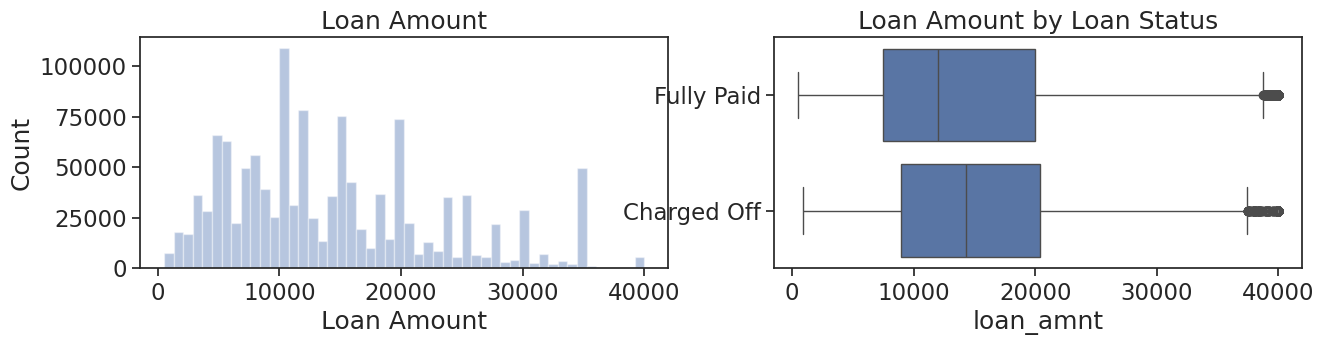

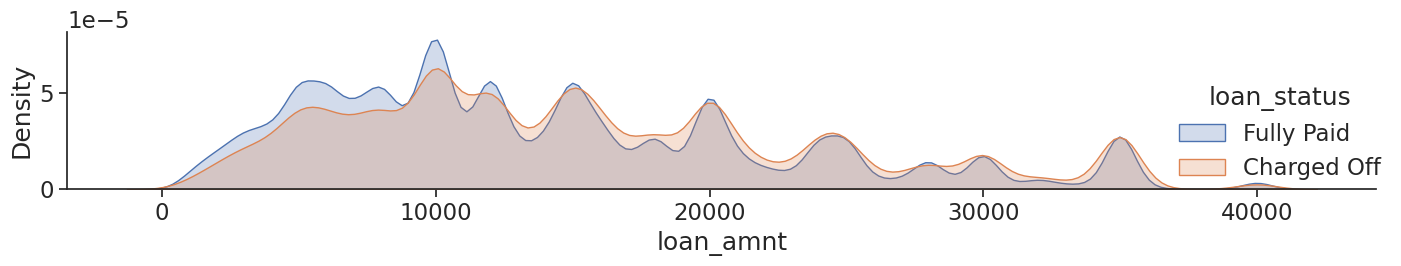

In [ ]:
plot_var('loan_amnt', 'Loan Amount', continuous=True)

# term
Data Dictionary: "The number of payments on the loan. Values are in months and can be either 36 or 60."

In [ ]:
df['term'] = df['term'].apply(lambda s: np.int8(s.split()[0]))

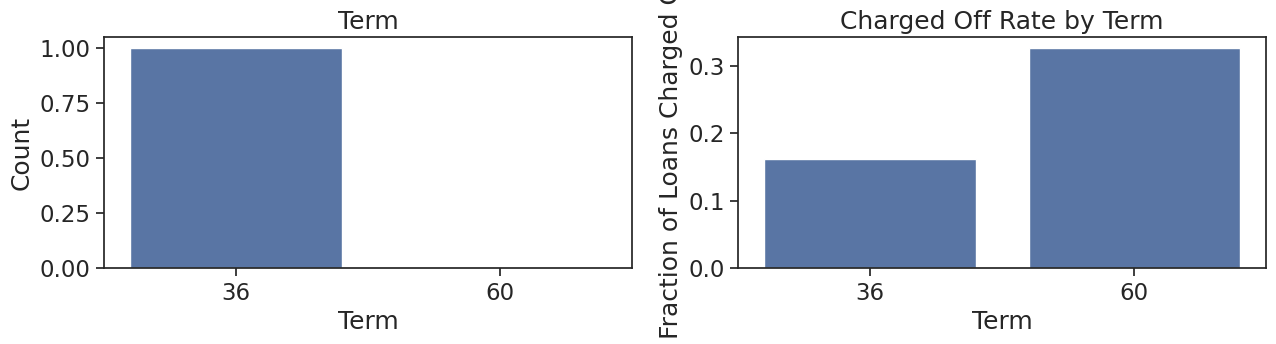

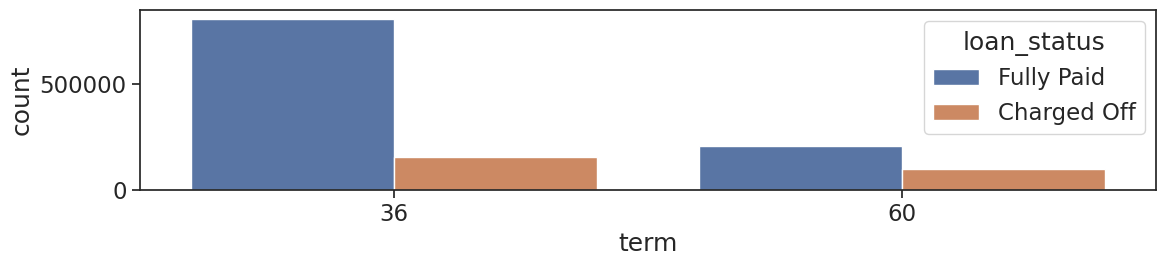

In [ ]:
plot_var('term', 'Term', continuous=False)

In [ ]:
df['term'].value_counts(normalize=True)

term
36    0.758545
60    0.241455
Name: proportion, dtype: float64

About 76% of the loans are 36 months and the rest are 60 months. The latter tends to have lower fraction of being fully paid.

Compare the charge-off rate by loan period

In [ ]:
df.groupby('term')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

term
36    0.161336
60    0.326216
Name: proportion, dtype: float64

17% of the 36-month loans are charge off, while 33% of the 60-month are charged off. Longer term leads to higher charged off? This feature should be useful in modeling.

# int_rate
Data Dictionary: "Interest Rate on the loan."

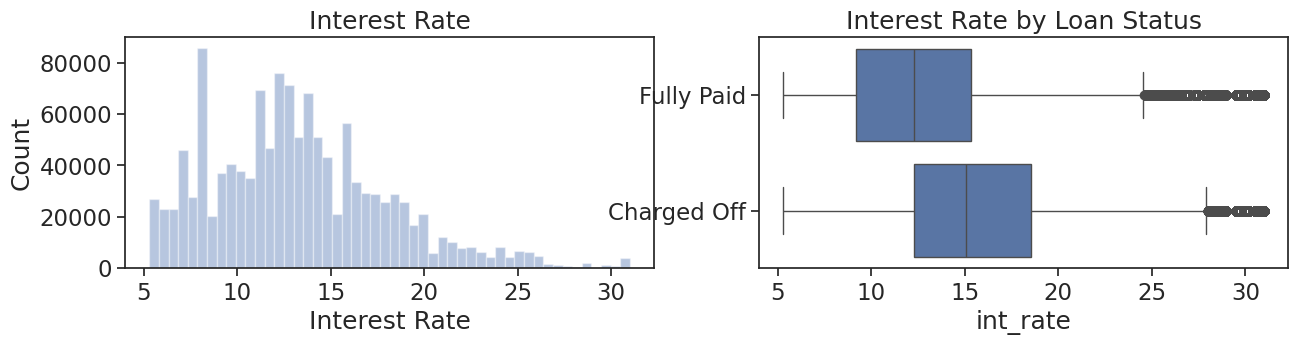

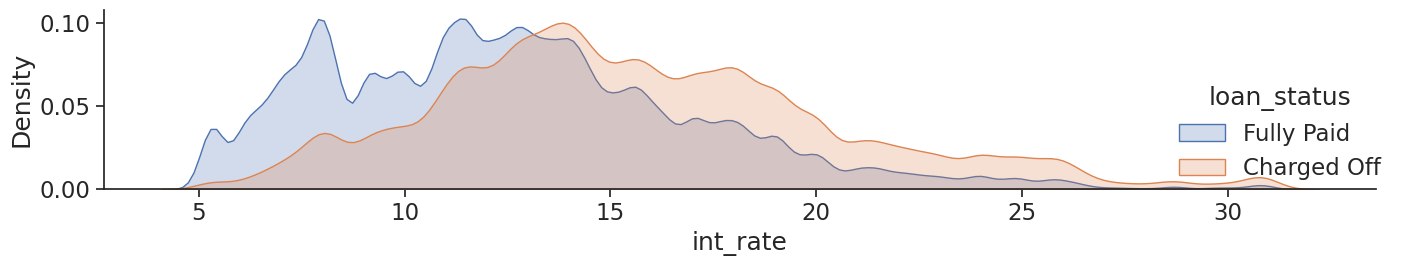

In [ ]:
plot_var('int_rate', 'Interest Rate', continuous=True)

The higher the interest rate is, the more likely for being charged off. There are some outliers in the Fully Paid dataset. Let's take a look at them, as outliers may distort ML analysis.

# Outliers
outliers can be exactly what we want to learn about, e.g., anomaly detection.
In this project, however, outliers may distort the picture of the data in both statistical analysis and visualization.
Below, I use the modified Z-score method and the IQR method. Note that the variable must be continuous, not categorical, for any of these functions to make sense.

In [ ]:
def outliers_modified_z_score(dataframe, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices corresponding to the observations containing more than n outliers according to the modified z-score Method
    """
    threshold = 3.5
    outlier_indices = []
    for col in features:
        median_y = np.median(dataframe[col])
        median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in dataframe[col]])
        modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in dataframe[col]]
        outlier_list_col = dataframe[np.abs(modified_z_scores) > threshold].index
       # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)
        # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers

#Outliers_to_drop_z_score = outliers_modified_z_score(df,2,['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'dti','fico_range_high', 'pub_rec', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mort_acc','earliest_cr_line_'])

In [ ]:
def outliers_iqr(dataframe, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    for col in features:
        # 1st quartile (25%) & # 3rd quartile (75%)
        quartile_1, quartile_3 = np.percentile(dataframe[col], [25,75])
        #quartile_3 = np.percentile(dataframe[col], 75)

        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr * 1.5)
        upper_bound = quartile_3 + (iqr * 1.5)
        # Determine a list of indices of outliers for feature col
        outlier_list_col = dataframe[(dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)].index
       # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)
        # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers

In [ ]:
df.groupby('loan_status')['int_rate'].describe()

count       mean       std   min    25%    50%    75%    max
loan_status                                                                  
Charged Off   254777.0  15.712771  4.885426  5.31  12.29  15.05  18.55  30.99
Fully Paid   1011841.0  12.650922  4.514129  5.31   9.17  12.29  15.31  30.99

In [ ]:
df.loc[(df.int_rate > 15.61) & (df.loan_status == 'Fully Paid')].shape[0]

221334

In [ ]:
(df.loc[(df.int_rate > 15.61) & (df.loan_status == 'Fully Paid')].shape[0])/df['loan_status'].value_counts(normalize=False, dropna=False)[0]

0.21874385402449595

In [ ]:
df.loc[(df.int_rate >18.55) & (df.loan_status == 'Charged Off')].shape[0]/df['loan_status'].value_counts(normalize=False, dropna=False)[1]

0.2450966924015904

The percentage of outliers is roughly the same for the Fully Paid/Charged off data, ~23%. A bit too much to be dropped.

# installment
Data Dictionary: "The monthly payment owed by the borrower if the loan originates."

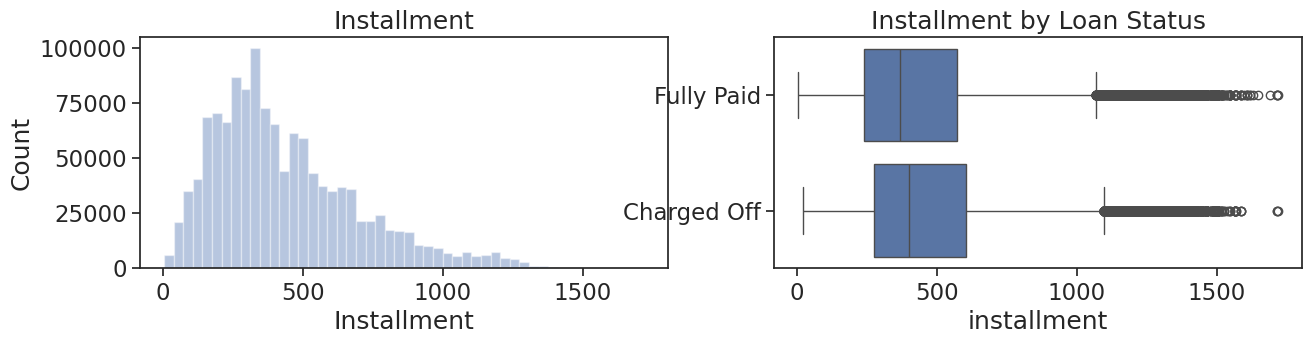

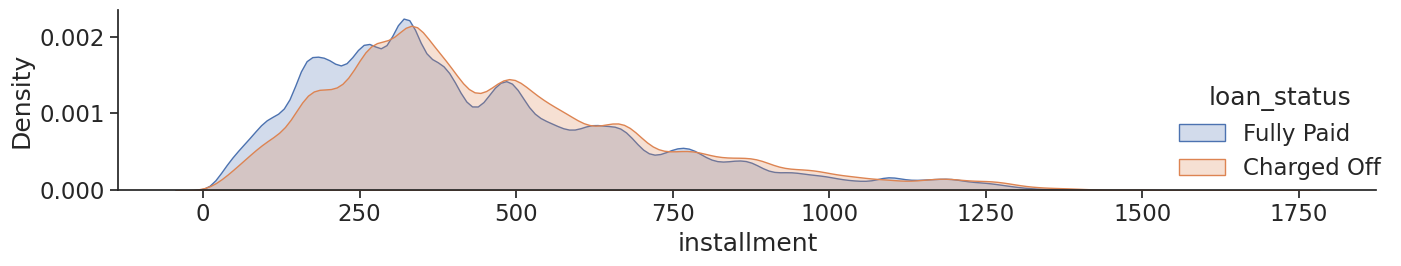

In [ ]:
plot_var('installment', 'Installment', continuous=True)

In [ ]:
df.groupby('loan_status')['installment'].describe()

count        mean         std    min     25%     50%     75%  \
loan_status                                                                     
Charged Off   254777.0  464.421451  261.900634  21.62  275.33  402.74  603.79   
Fully Paid   1011841.0  431.416841  259.888796   4.93  241.53  368.94  572.95   

                 max  
loan_status           
Charged Off  1717.63  
Fully Paid   1719.83

# grade, sub_grade
Data Dictionary for grade: "assigned loan grade." Data Dictionary for sub_grade: "LC assigned loan subgrade."

What are the possible values of grade and sub_grade?

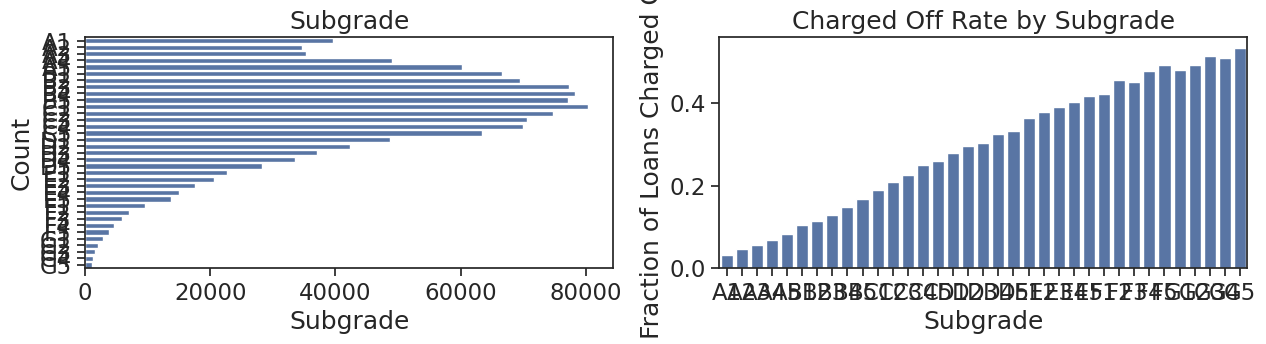

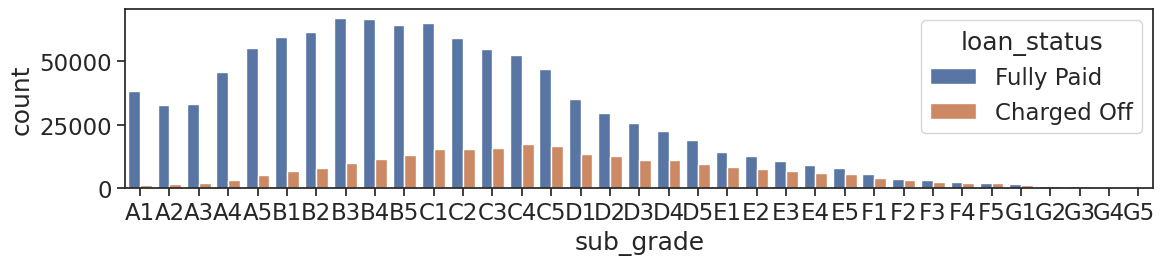

In [ ]:
plot_var('sub_grade','Subgrade',continuous=False)

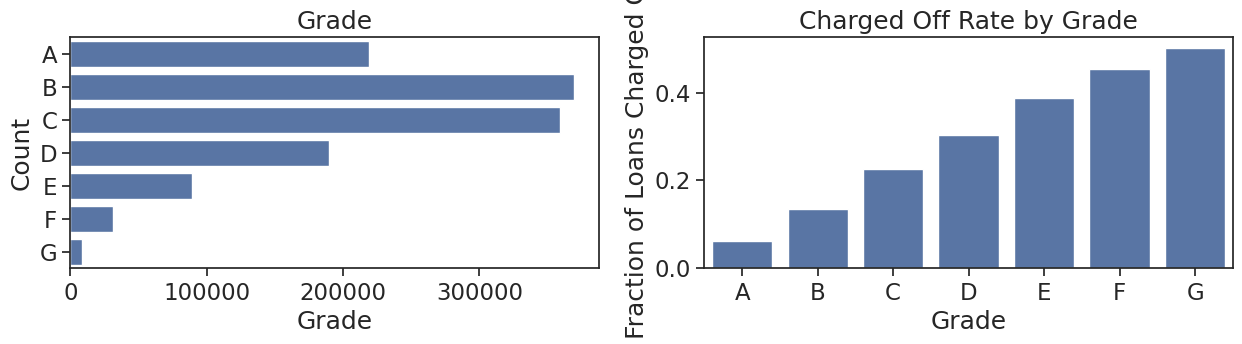

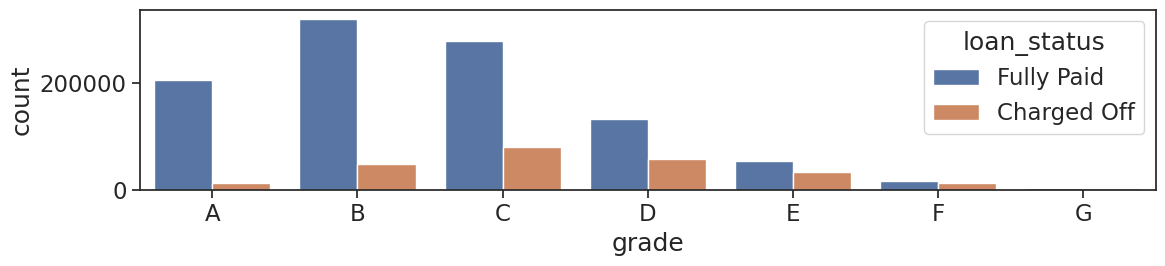

In [ ]:
plot_var('grade','Grade',continuous=False)

# emp_title
Data Dictionary: "The job title supplied by the Borrower when applying for the loan."

In [ ]:
drop_cols('emp_title')

# emp_length
Data Dictionary: "Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years." The actual data does not match this description:

In [ ]:
df['emp_length'].value_counts(dropna=False).sort_index()

emp_length
1 year        83267
10+ years    416124
2 years      114492
3 years      101223
4 years       75854
5 years       79357
6 years       59341
7 years       56836
8 years       57721
9 years       48247
< 1 year     101439
NaN           72717
Name: count, dtype: int64

In [ ]:
df['emp_length'].replace('10+ years', '10 years', inplace=True)

In [ ]:
df['emp_length'].replace('< 1 year', '0 years', inplace=True)

In [ ]:
df['emp_length'].value_counts(dropna=False).sort_index()

emp_length
0 years     101439
1 year       83267
10 years    416124
2 years     114492
3 years     101223
4 years      75854
5 years      79357
6 years      59341
7 years      56836
8 years      57721
9 years      48247
NaN          72717
Name: count, dtype: int64

In [ ]:
df.emp_length.map( lambda x: str(x).split()[0]).value_counts(dropna=True).sort_index()

emp_length
0      101439
1       83267
10     416124
2      114492
3      101223
4       75854
5       79357
6       59341
7       56836
8       57721
9       48247
nan     72717
Name: count, dtype: int64

In [ ]:
df['emp_length'] = df.emp_length.map( lambda x: float(str(x).split()[0]))

In [ ]:
df['emp_length'].sample(5)

1805340    10.0
1687942    10.0
276343      0.0
1859713    10.0
2000392     6.0
Name: emp_length, dtype: float64

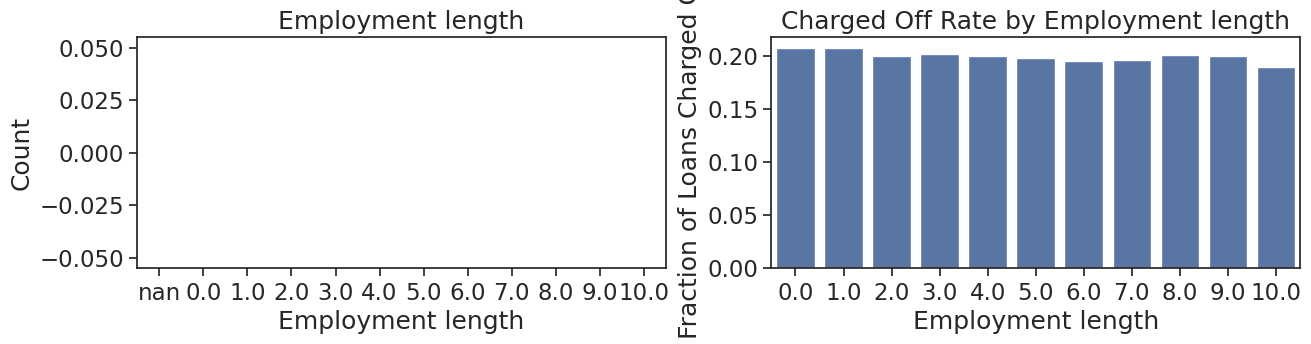

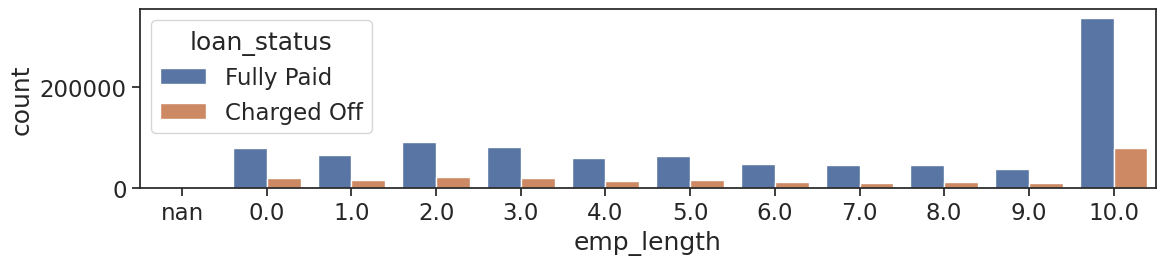

In [ ]:
plot_var('emp_length', 'Employment length', continuous=False)

One third of the loans go to the people with longer than 10 years of employments. However, the fully paid rate seems not quite related to this feature. Again, this will be further examined in a statistical test at the end.

# home_ownership
Data Dictionary: "The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER."

In [ ]:
df['home_ownership'].value_counts()

home_ownership
MORTGAGE    627679
RENT        503075
OWN         135425
ANY            247
OTHER          144
NONE            48
Name: count, dtype: int64

In [ ]:
df['home_ownership'].value_counts()

home_ownership
MORTGAGE    627679
RENT        503075
OWN         135425
ANY            247
OTHER          144
NONE            48
Name: count, dtype: int64

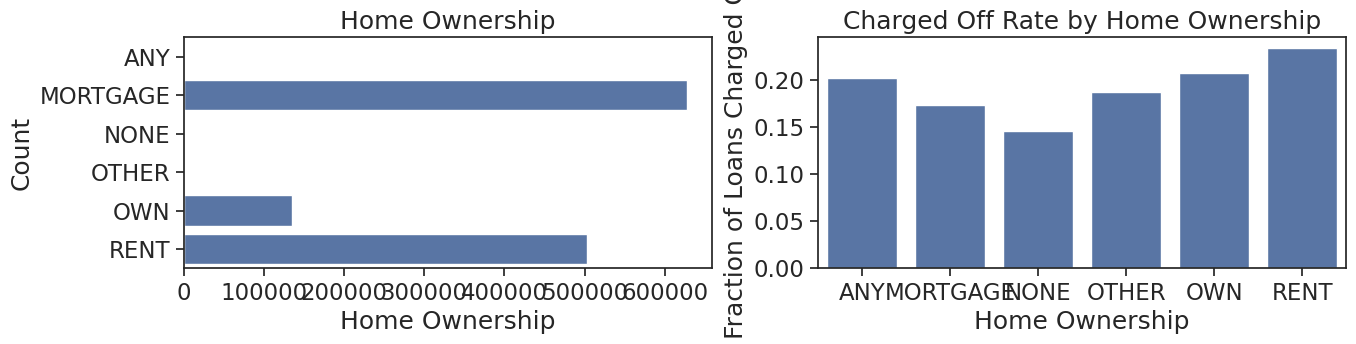

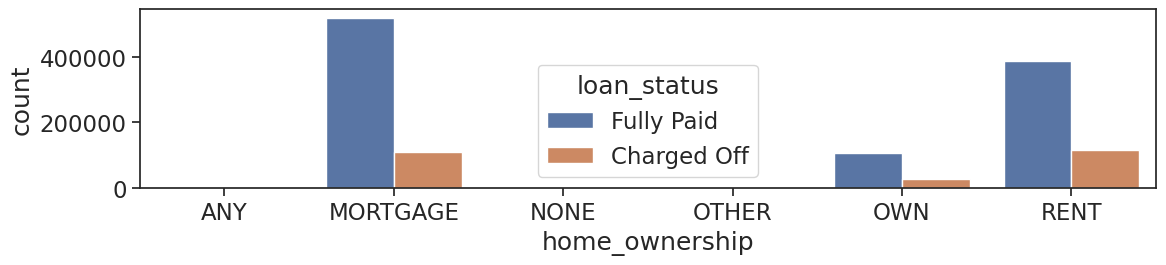

In [ ]:
plot_var('home_ownership', 'Home Ownership', continuous=False)

In [ ]:
df.groupby('home_ownership')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

home_ownership
ANY         0.202429
MORTGAGE    0.173390
NONE        0.145833
OTHER       0.187500
OWN         0.208034
RENT        0.233935
Name: proportion, dtype: float64

There appear to be small differences in charge-off rates by home ownership status. Mortgage & OTHER has slightly less probability of Charged-Off. Because of the large numbers of observations in each category, these differences might be statistically significant.

# annual_inc
Data Dictionary: "The self-reported annual income provided by the borrower during registration."

In [ ]:
df['annual_inc'] = df['annual_inc'].apply(lambda x:np.log10(x+1))

In [ ]:
df['annual_inc'].describe()

count    1.266618e+06
mean     4.812689e+00
std      2.438659e-01
min      0.000000e+00
25%      4.660875e+00
50%      4.812920e+00
75%      4.954247e+00
max      7.041361e+00
Name: annual_inc, dtype: float64

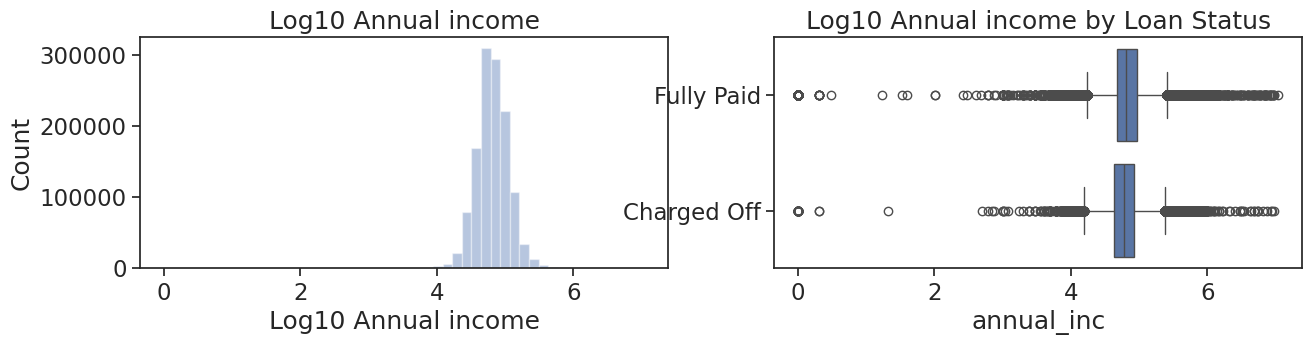

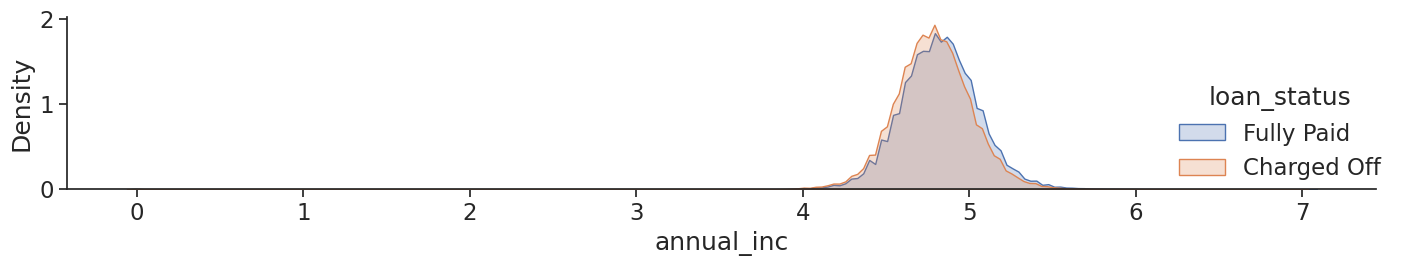

In [ ]:
plot_var('annual_inc', 'Log10 Annual income', continuous=True)

In [ ]:
df.groupby('loan_status')['annual_inc'].describe()

count      mean       std  min       25%       50%       75%  \
loan_status                                                                     
Charged Off   254777.0  4.781671  0.238319  0.0  4.633479  4.778158  4.929424   
Fully Paid   1011841.0  4.820499  0.244624  0.0  4.672107  4.812920  4.966146   

                  max  
loan_status            
Charged Off  6.977724  
Fully Paid   7.041361

For both cases, there are quite a few outliers (in the lower end).

# verification_status
Data Dictionary: "Indicates if income was verified by [Lending Club], not verified, or if the income source was verified."

In [ ]:
df['verification_status'].value_counts()

verification_status
Source Verified    488466
Verified           397995
Not Verified       380157
Name: count, dtype: int64

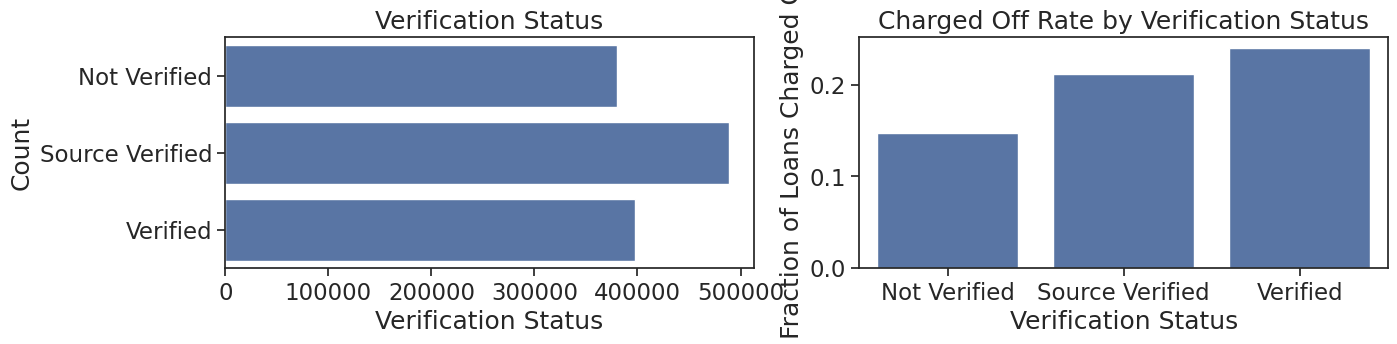

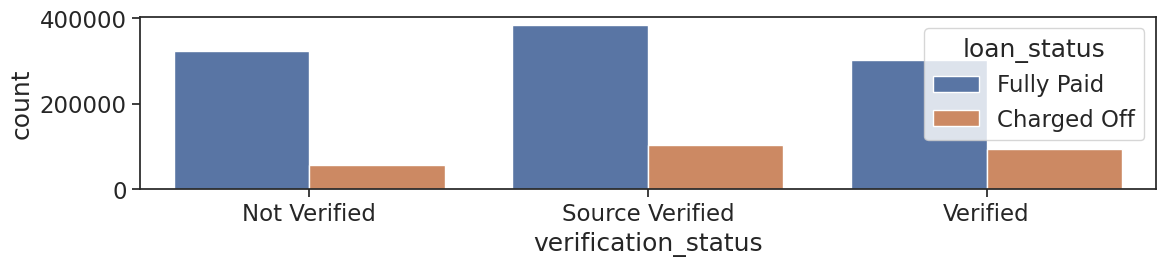

In [ ]:
plot_var('verification_status', 'Verification Status', continuous=False)

Surprisingly, verified loans have higher chance of being charged-Off.

# purpose
Data Dictionary: "A category provided by the borrower for the loan request."

In [ ]:
df['purpose'].value_counts()

purpose
debt_consolidation    737263
credit_card           277324
home_improvement       81942
other                  72304
major_purchase         27416
small_business         14617
medical                14474
car                    13693
moving                  8928
vacation                8460
house                   6693
wedding                 2294
renewable_energy         884
educational              326
Name: count, dtype: int64

In [ ]:
df.groupby('purpose')['loan_status'].value_counts(normalize=True)[:,'Charged Off'].sort_values(ascending=False)

purpose
small_business        0.298693
renewable_energy      0.239819
moving                0.235999
medical               0.219635
house                 0.216644
debt_consolidation    0.213014
other                 0.212118
vacation              0.192199
major_purchase        0.186497
home_improvement      0.178883
educational           0.171779
credit_card           0.170721
car                   0.146206
wedding               0.121622
Name: proportion, dtype: float64

We see that, 30% of the loans for small_business are charged off, but only 12% of wedding are charged Off.

# title
Data Dictionary: "The loan title provided by the borrower."

In [ ]:
drop_cols('title')

# zip_code, addr_stat
Data Dictionary for zip_code: "The first 3 numbers of the zip code provided by the borrower in the loan application."
Data Dictionary for addr_state: "The state provided by the borrower in the loan application."

In [ ]:
df['zip_code'].describe()

count     1266618
unique        942
top         945xx
freq        14262
Name: zip_code, dtype: object

In [ ]:
df['addr_state'].describe()

count     1266618
unique         51
top            CA
freq       186020
Name: addr_state, dtype: object

There are many unique "zip_code" values, and the zip_code info should be equivalent to "addr_stat". Therefore we drop the "zip_code".

In [ ]:
drop_cols('zip_code')

In [ ]:
df.groupby('addr_state')['loan_status'].value_counts(normalize=True)[:,'Charged Off'].sort_values(ascending=False)

addr_state
MS    0.261528
NE    0.253060
AR    0.242231
AL    0.237764
OK    0.237663
LA    0.234482
NY    0.221919
NV    0.220328
TN    0.217989
IN    0.216956
FL    0.215848
MO    0.214755
NM    0.214614
MD    0.214079
SD    0.213600
NJ    0.213206
KY    0.212321
ND    0.211445
NC    0.209484
OH    0.209401
PA    0.209273
MI    0.204293
HI    0.202905
DE    0.202190
VA    0.201389
AK    0.200462
MN    0.199858
TX    0.199622
CA    0.197205
AZ    0.196878
MA    0.191462
ID    0.191216
GA    0.185081
WI    0.182397
IL    0.182396
RI    0.180997
CT    0.176034
UT    0.173051
WY    0.171305
MT    0.169906
KS    0.168949
SC    0.164909
WV    0.160310
WA    0.158896
CO    0.155940
NH    0.146047
OR    0.145144
IA    0.142857
VT    0.141353
ME    0.140312
DC    0.129997
Name: proportion, dtype: float64


MS has the highest fraction of Charged Off (0.28), whereas DC has the lowest fraction at 0.13.

# dti
Data Dictionary: "A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."

Text(0.5, 1.0, 'DTI by loan status')

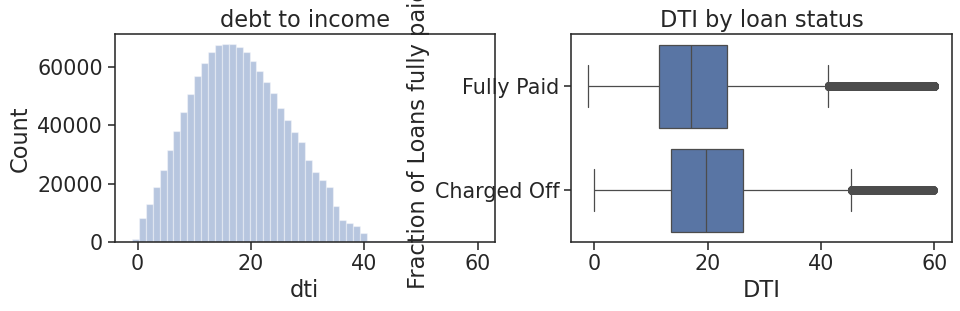

In [ ]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
sns.distplot(df.loc[df['dti'].notnull() & (df['dti'] < 60), 'dti'], kde=False, ax=ax1)
ax1.set_xlabel('dti')
ax1.set_ylabel('Count')
ax1.set_title('debt to income')
sns.boxplot(x=df.loc[df['dti'].notnull() & (df['dti'] < 60), 'dti'], y='loan_status', data=df, ax=ax2)
ax2.set_xlabel('DTI')
ax2.set_ylabel('Fraction of Loans fully paid')
ax2.set_title('Fully paid rate by debt to income')
ax2.set_title('DTI by loan status')

In [ ]:
df.groupby('loan_status')['dti'].median()

loan_status
Charged Off    19.79
Fully Paid     17.08
Name: dti, dtype: float64

It's clear that borrowers who have higher DTI are more likely to be charged off

# open_acc
Data Dictionary: "The number of open credit lines in the borrower's credit file."

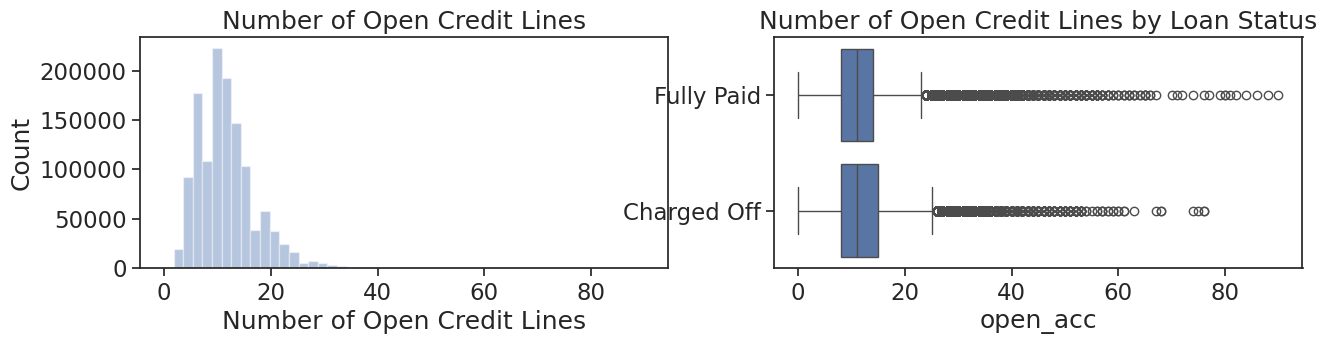

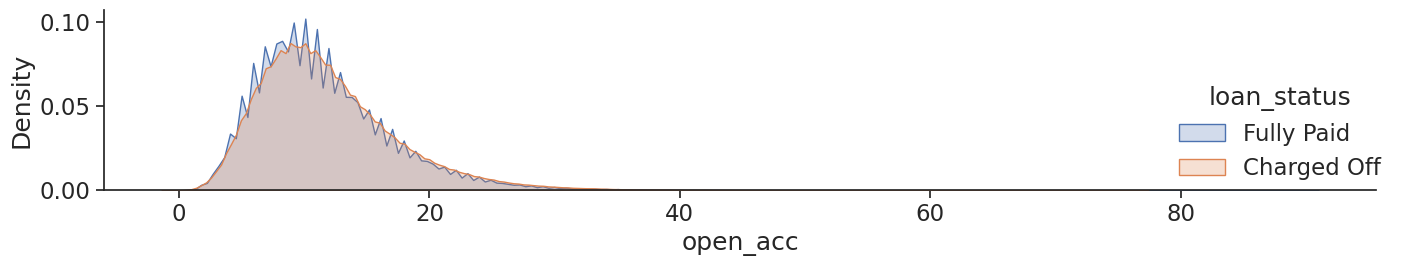

In [ ]:
plot_var('open_acc', 'Number of Open Credit Lines', continuous=True)

There seems no significant difference in number of credit lines between fully paid loans and charged-off loans.

In [ ]:
df.groupby('loan_status')['open_acc'].describe()

count       mean       std  min  25%   50%   75%   max
loan_status                                                            
Charged Off   254777.0  11.912402  5.627681  0.0  8.0  11.0  15.0  76.0
Fully Paid   1011841.0  11.509801  5.409937  0.0  8.0  11.0  14.0  90.0

# earliest_cr_line
Data Dictionary: "The month the borrower's earliest reported credit line was opened."

Rather than converting it to a date, I will use a scalar to describe the length of time since the first line of credit. If all other variables are held equal, the longer you have had lines of credit the better.

In [ ]:
from datetime import datetime

df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line)

dttoday = datetime.now().strftime('%Y-%m-%d')
df.earliest_cr_line = df.earliest_cr_line.apply(lambda x:(np.timedelta64((x - pd.Timestamp(dttoday)),'D').astype(int))/-365)

df.earliest_cr_line.shape

(1266618,)

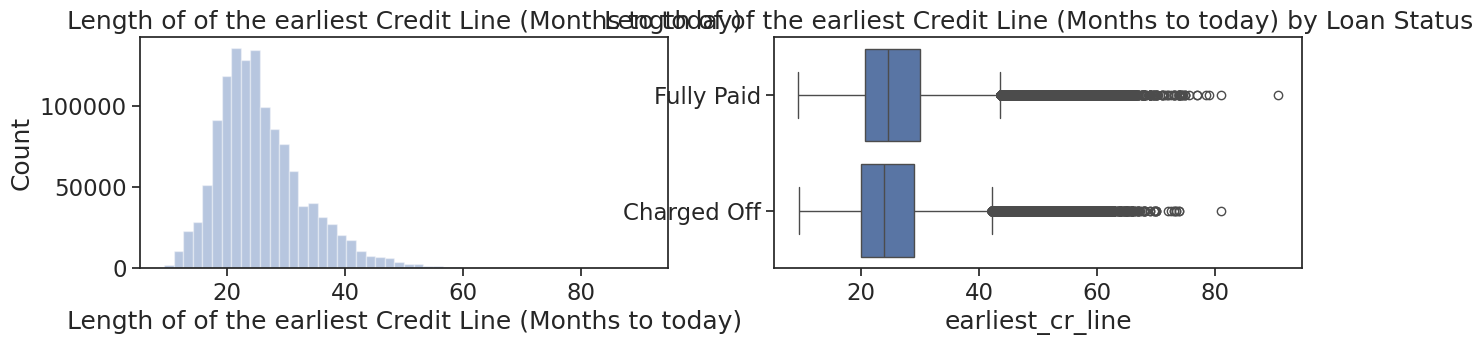

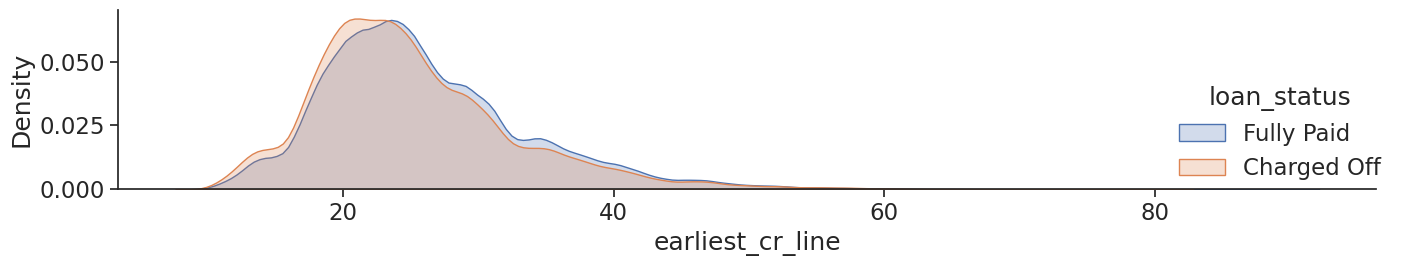

In [ ]:
plot_var('earliest_cr_line', 'Length of of the earliest Credit Line (Months to today)', continuous=True)

In [ ]:
df.groupby('loan_status')['earliest_cr_line'].describe()

count       mean       std       min        25%        50%  \
loan_status                                                                   
Charged Off   254777.0  25.155621  7.554826  9.487671  20.073973  23.824658   
Fully Paid   1011841.0  25.995456  7.577466  9.320548  20.745205  24.580822   

                   75%        max  
loan_status                        
Charged Off  28.915068  80.950685  
Fully Paid   29.915068  90.709589

# fico_range_low, fico_range_high
Data Dictionary for fico_range_low: "The lower boundary range the borrower’s FICO at loan origination belongs to."
Data Dictionary for fico_range_high: "The upper boundary range the borrower’s FICO at loan origination belongs to."

In [ ]:
df[['fico_range_low','fico_range_high']].describe()

fico_range_low  fico_range_high
count    1.266618e+06     1.266618e+06
mean     6.960092e+02     7.000093e+02
std      3.173401e+01     3.173463e+01
min      6.250000e+02     6.290000e+02
25%      6.700000e+02     6.740000e+02
50%      6.900000e+02     6.940000e+02
75%      7.100000e+02     7.140000e+02
max      8.450000e+02     8.500000e+02

In [ ]:
df[['fico_range_low','fico_range_high']].corr()

fico_range_low  fico_range_high
fico_range_low              1.0              1.0
fico_range_high             1.0              1.0

These two are highly correlated, therefore we only need to keep one. We create a new feature, "fico_score" which is the mean value of the "fico_range_low" and "fico_range_high"

In [ ]:
df['fico_score'] = (df['fico_range_low'] + df['fico_range_high'])/2.

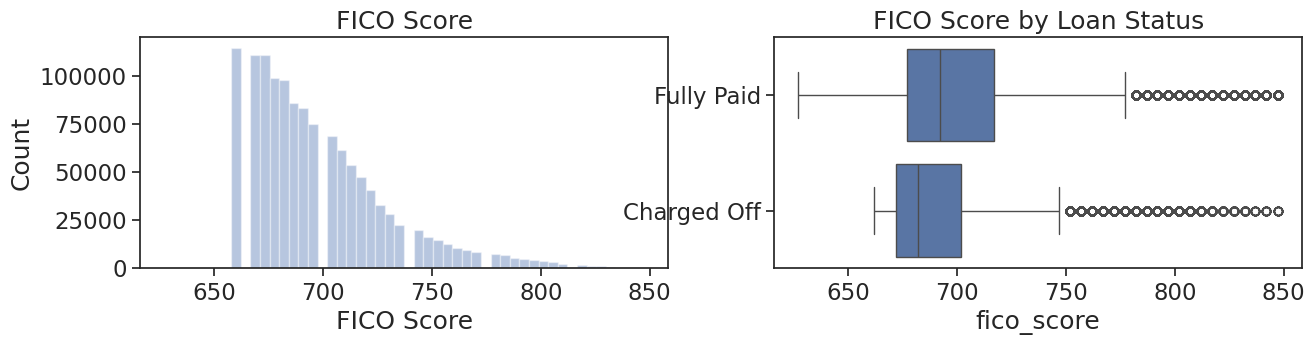

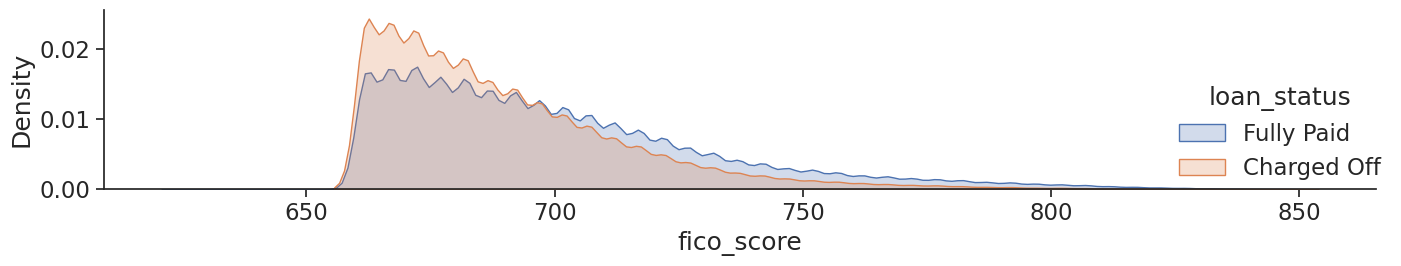

In [ ]:
plot_var('fico_score', 'FICO Score', continuous=True)

There is noticeable difference in FICO scores between fully paid and charged-off loans.

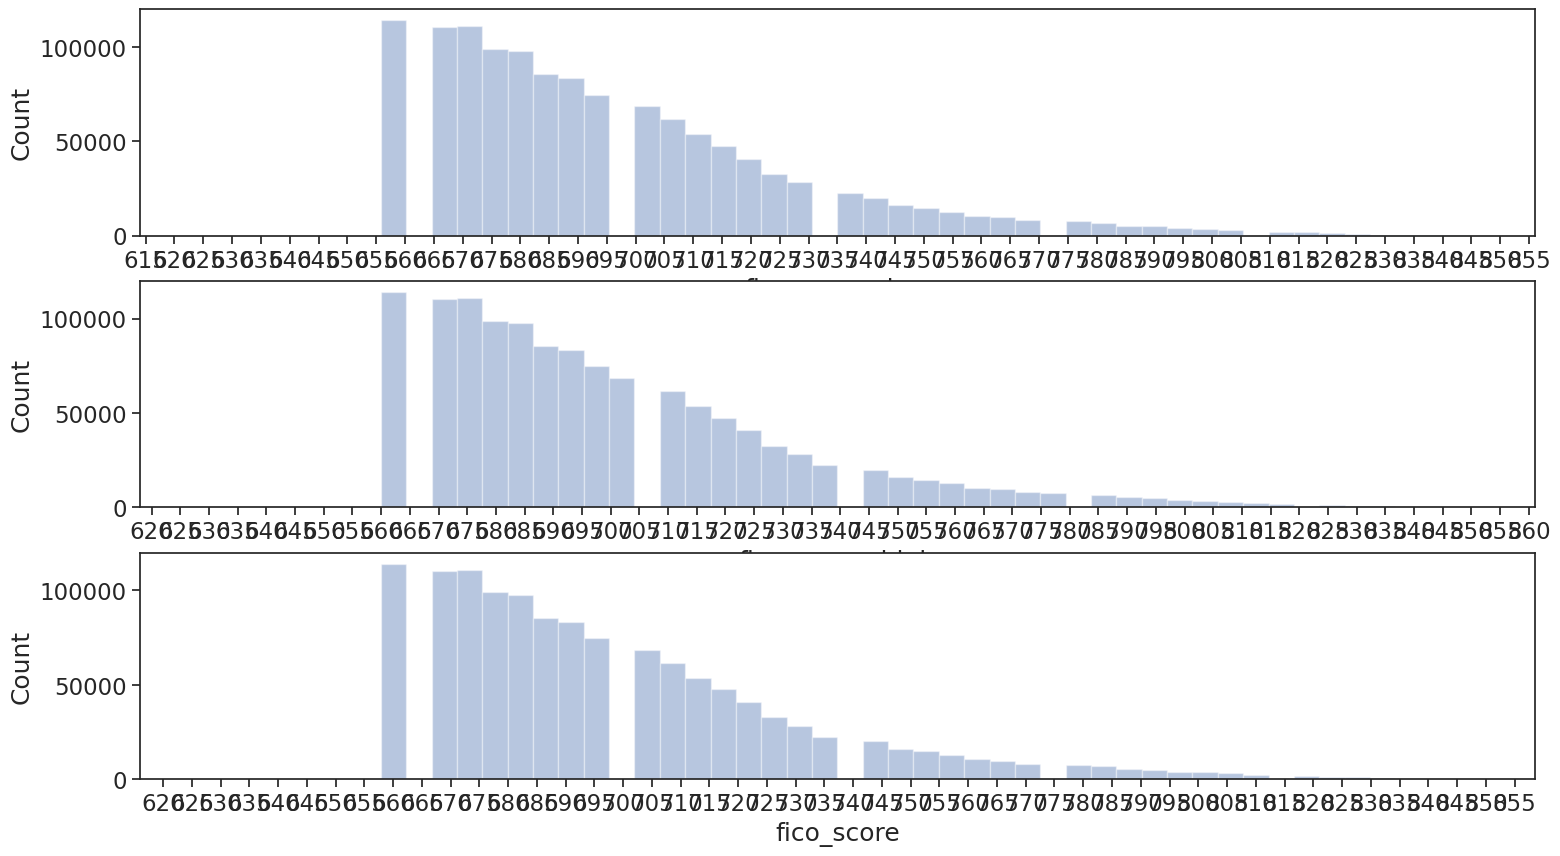

In [ ]:
import matplotlib.ticker as ticker

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, figsize=(18,10))
sns.distplot(df.loc[df['fico_range_low'].notnull(), 'fico_range_low'], kde=False, ax=ax1)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax1.set_ylabel('Count')

sns.distplot(df.loc[df['fico_range_high'].notnull(), 'fico_range_high'], kde=False, ax=ax2)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax2.set_ylabel('Count')

sns.distplot(df.loc[df['fico_score'].notnull(), 'fico_score'], kde=False, ax=ax3)
ax3.set_ylabel('Count')
ax3.xaxis.set_major_locator(ticker.MultipleLocator(5))

In [ ]:
df[['fico_score','open_acc','earliest_cr_line','dti']].corr()

fico_score  open_acc  earliest_cr_line       dti
fico_score          1.000000  0.017537          0.101589 -0.065265
open_acc            0.017537  1.000000          0.126201  0.231280
earliest_cr_line    0.101589  0.126201          1.000000  0.020351
dti                -0.065265  0.231280          0.020351  1.000000

In [ ]:
drop_cols(['fico_range_high','fico_range_low'])

# pub_rec
Data Dictionary: "Number of derogatory public records."

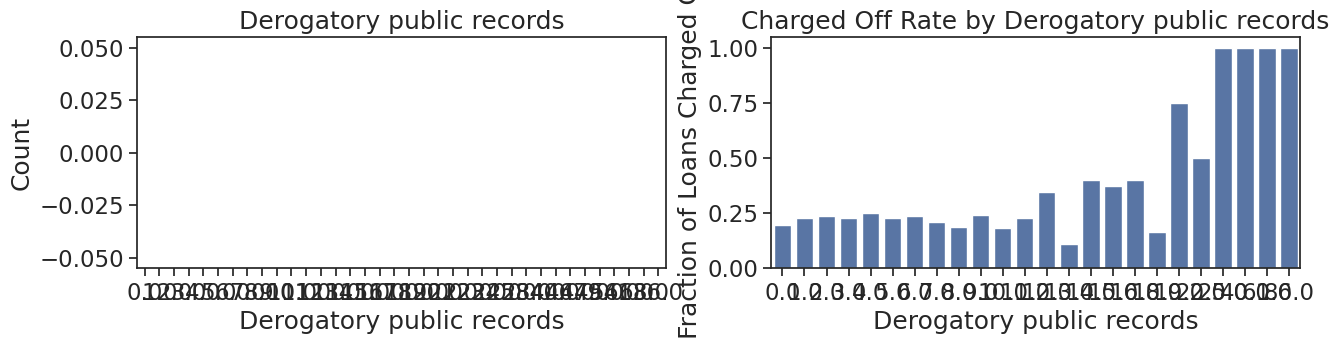

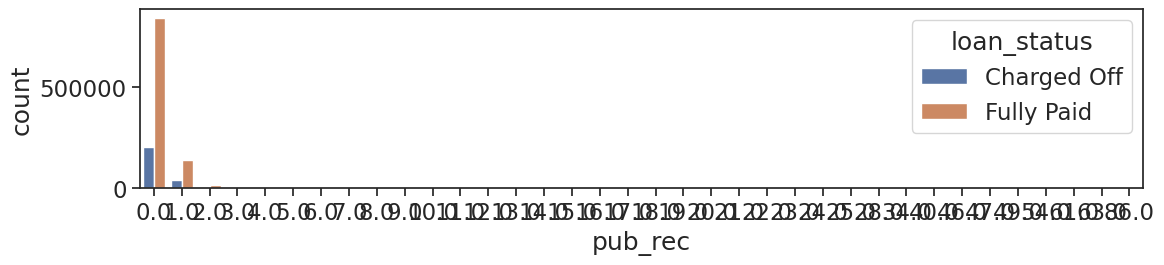

In [ ]:
plot_var('pub_rec','Derogatory public records', continuous=False)

we group the few bins with lower values together into 1 bin

In [ ]:
df.pub_rec = df.pub_rec.map(lambda x: 3 if x >2.0 else x)

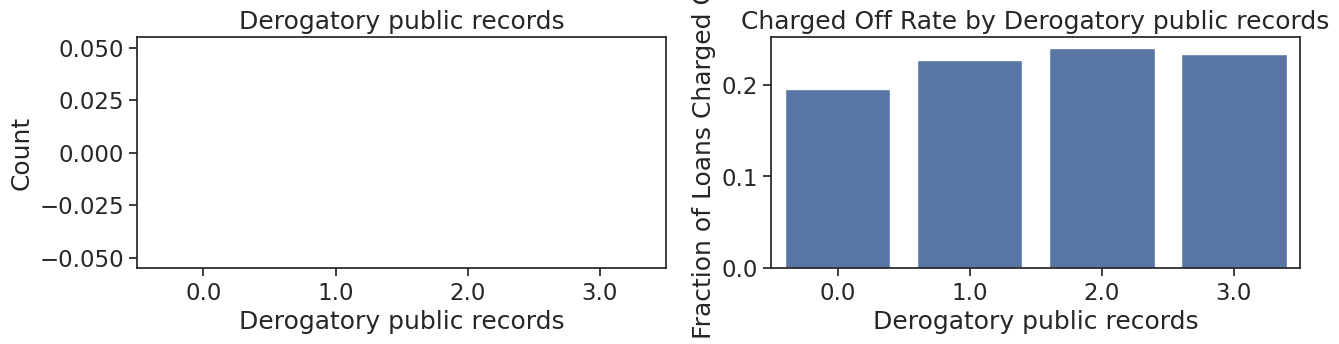

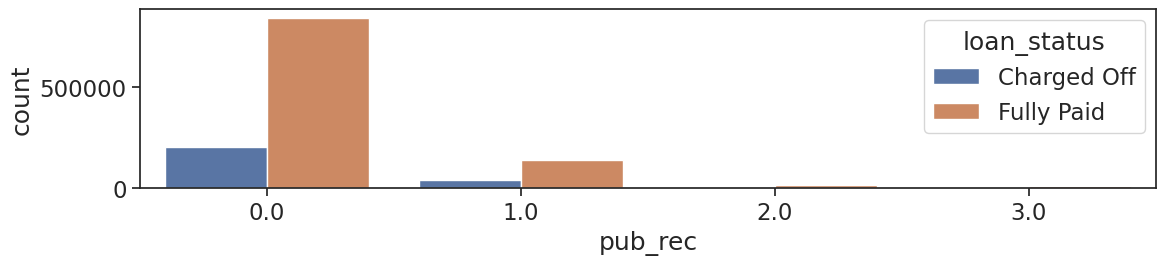

In [ ]:
plot_var('pub_rec','Derogatory public records', continuous=False)

In [ ]:
df.groupby('loan_status')['pub_rec'].describe()

count      mean       std  min  25%  50%  75%  max
loan_status                                                        
Charged Off   254777.0  0.236560  0.538165  0.0  0.0  0.0  0.0  3.0
Fully Paid   1011841.0  0.199249  0.498406  0.0  0.0  0.0  0.0  3.0

After grouping, it is clear that: pub_rec are mostly 0 & 1; pub_rec with 1 and higher have higher chance of being charged off than pub_rec of 0.

# pub_rec_bankruptcies
Data Dictionary: "Number of public record bankruptcies."

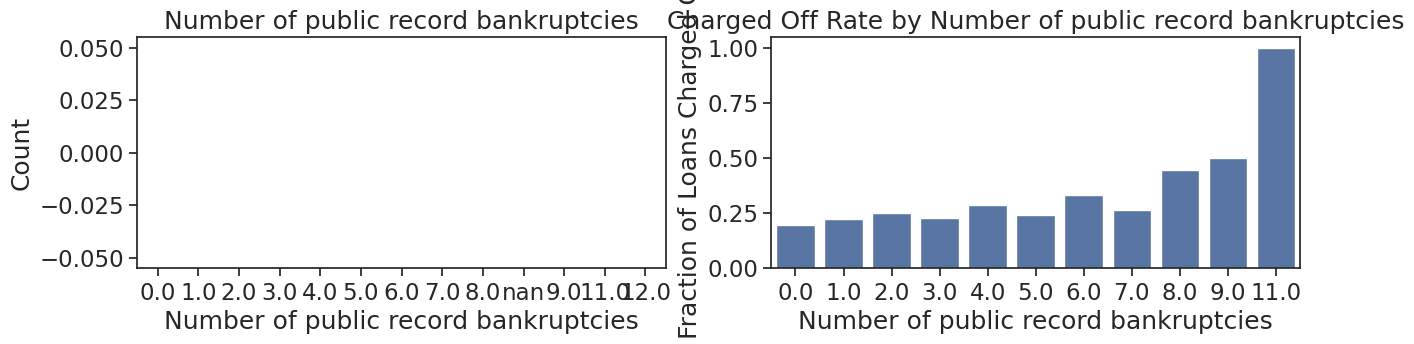

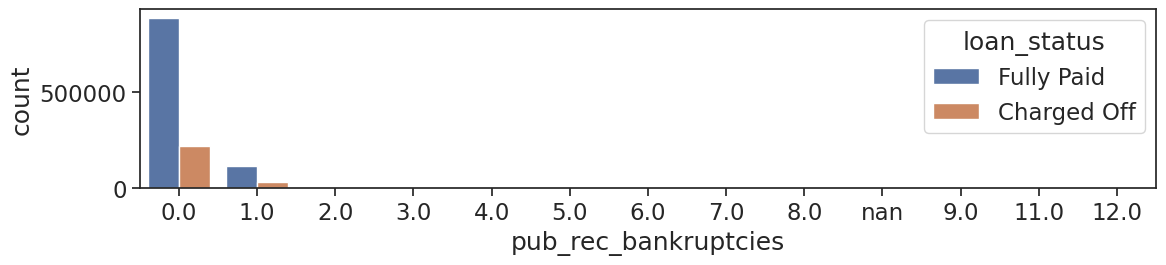

In [ ]:
plot_var('pub_rec_bankruptcies', 'Number of public record bankruptcies', continuous=False)

In [ ]:
df[['pub_rec','pub_rec_bankruptcies']].corr()

pub_rec  pub_rec_bankruptcies
pub_rec               1.000000              0.736018
pub_rec_bankruptcies  0.736018              1.000000

"pub_rec" and "pub_rec_bankruptcies" are highly correlated. could only feed one of them into the modeling.

# revol_bal
Data Dictionary: "Total credit revolving balance."

In [ ]:
df['revol_bal'] = df['revol_bal'].apply(lambda x:np.log10(x+1))

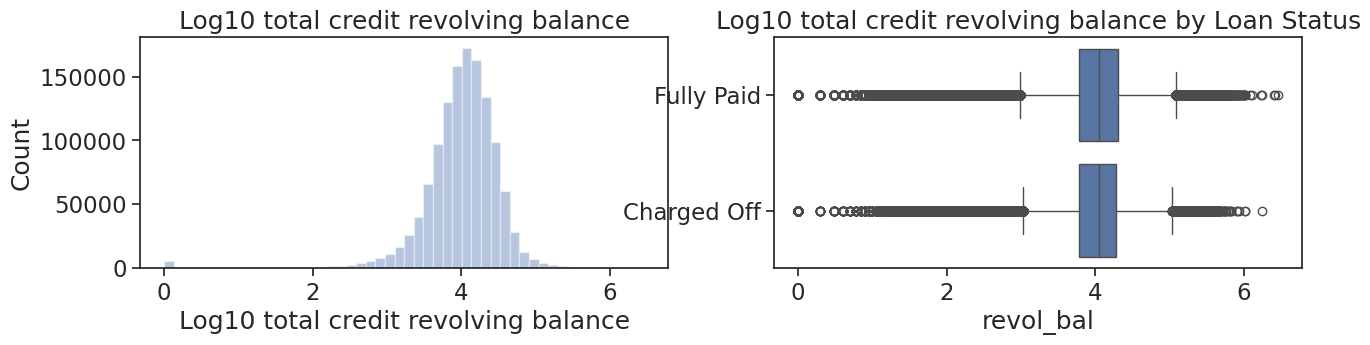

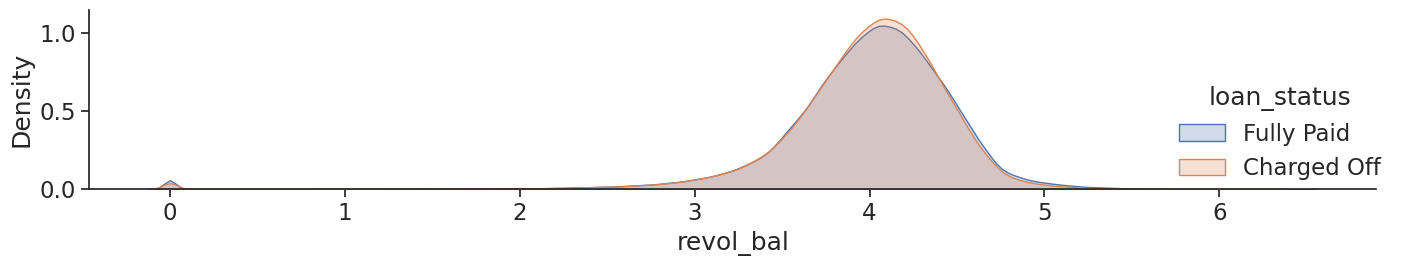

In [ ]:
plot_var('revol_bal', 'Log10 total credit revolving balance', continuous=True)

# revol_util
Data Dictionary: "Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit."

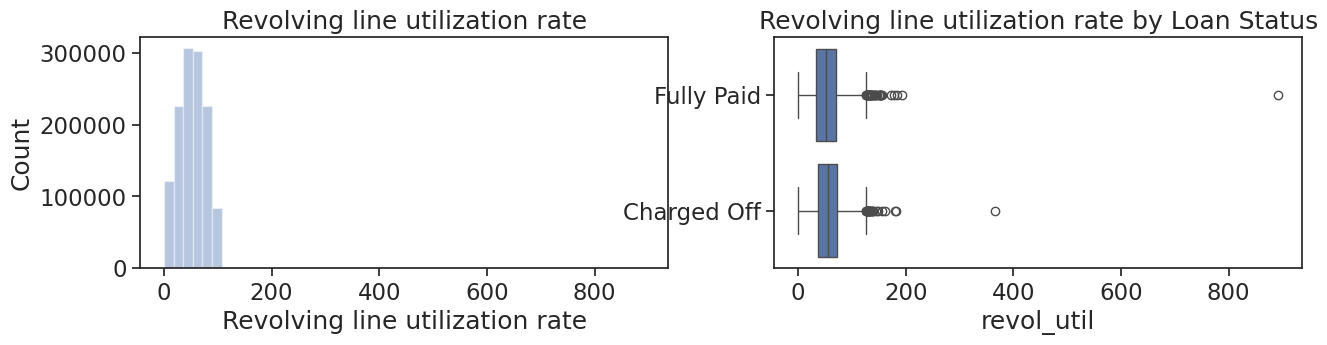

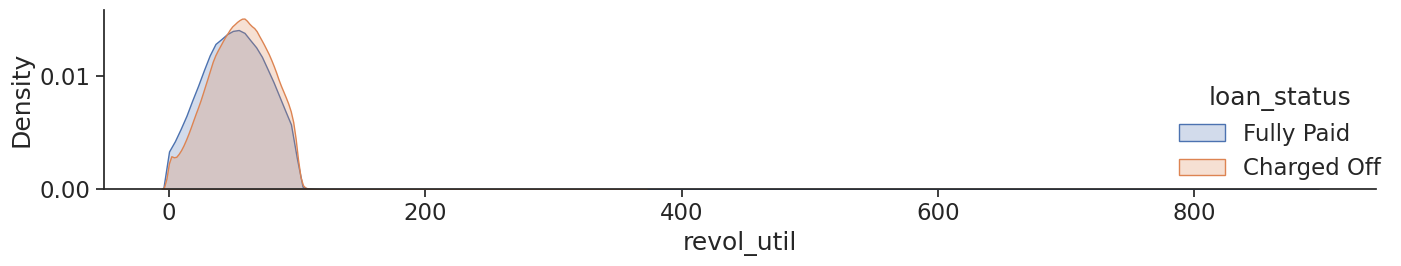

In [ ]:
plot_var('revol_util', 'Revolving line utilization rate', continuous=True)

In [ ]:
df.groupby('loan_status')['revol_util'].describe()

count       mean        std  min   25%   50%   75%    max
loan_status                                                               
Charged Off   254614.0  55.030503  23.793468  0.0  37.8  55.9  73.3  366.6
Fully Paid   1011226.0  51.255757  24.582075  0.0  32.7  51.5  70.2  892.3


Charged Off loans tend to have higher revol_util.

# total_acc
Data Dictionary: "The total number of credit lines currently in the borrower's credit file."

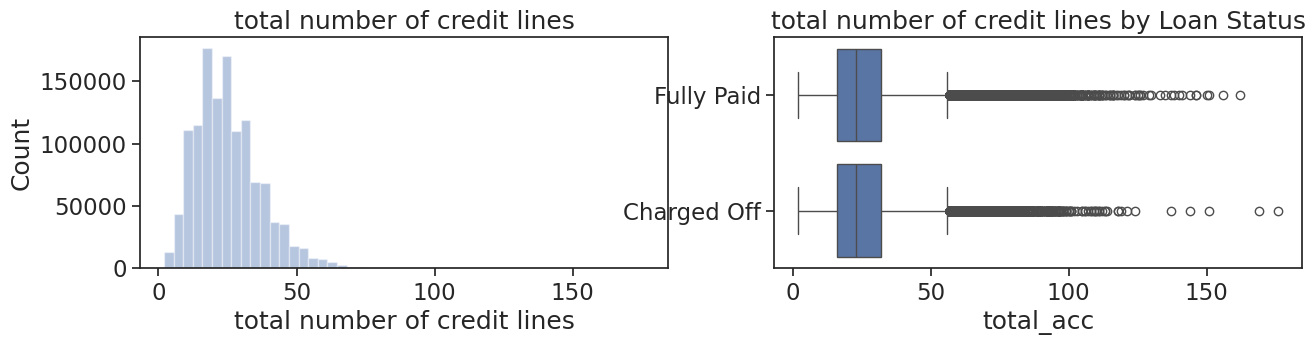

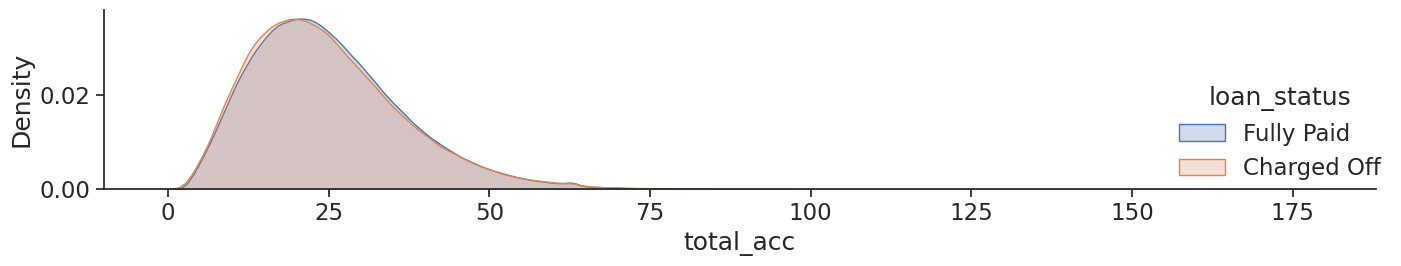

In [ ]:
plot_var('total_acc', 'total number of credit lines', continuous=True)

# initial_list_status
Data Dictionary: "The initial listing status of the loan. Possible values are – W, F (whole vs. fractional)

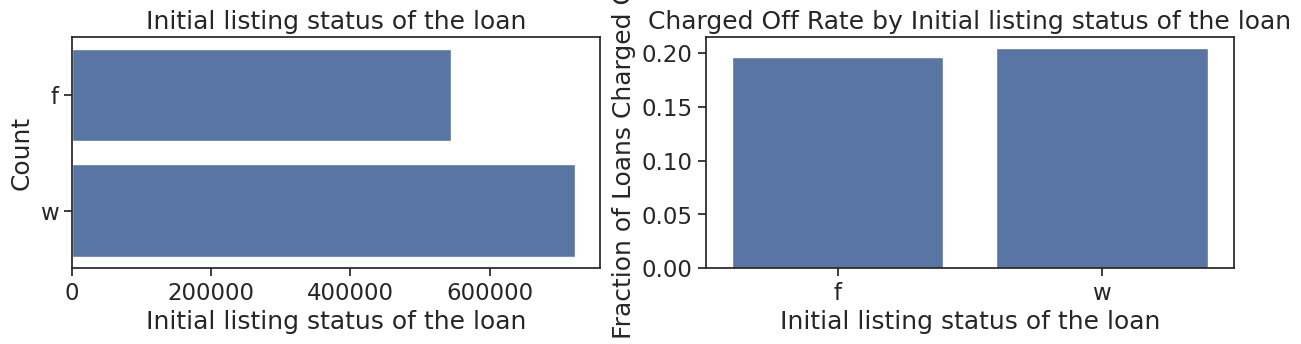

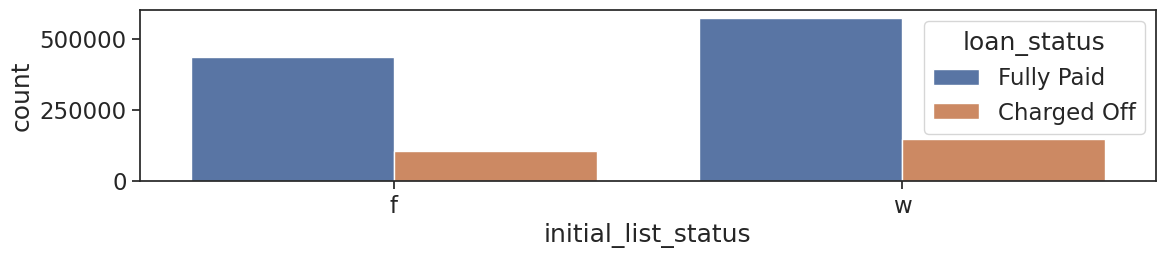

In [ ]:
plot_var('initial_list_status','Initial listing status of the loan', continuous=False)

# policy_code
Data Dictionary: "publicly available policy_code=1; new products not publicly available policy_code=2"

In [ ]:
drop_cols('policy_code')

# application_type
Data Dictionary: "Indicates whether the loan is an individual application or a joint application with two co-borrowers."

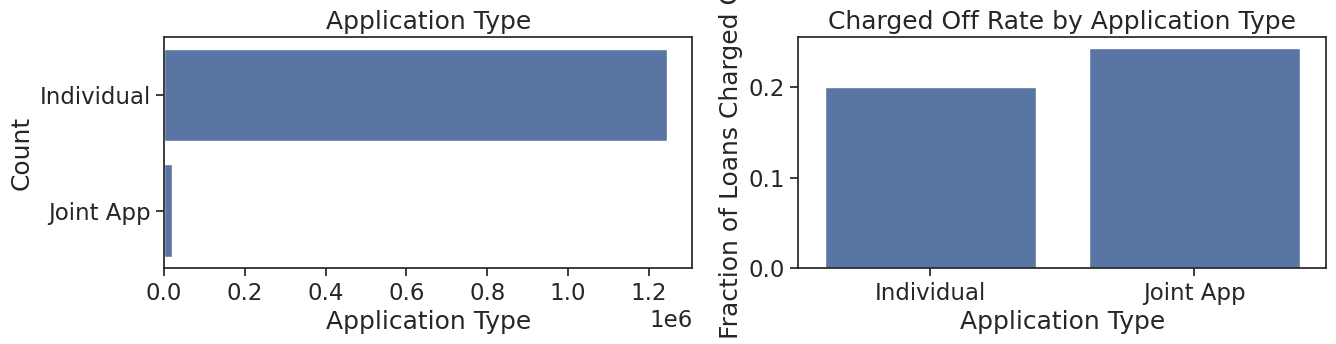

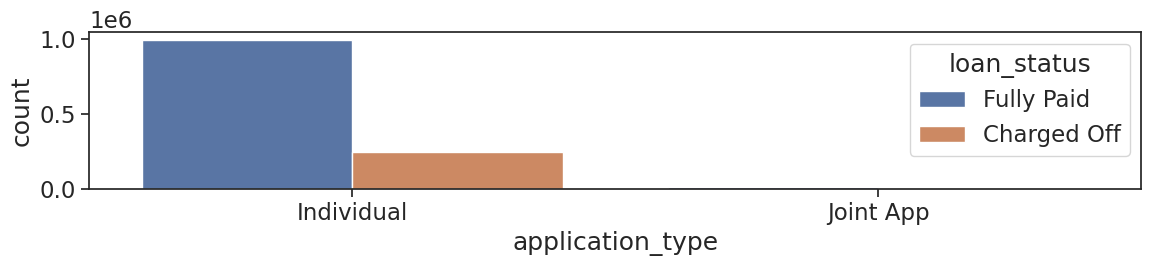

In [ ]:
plot_var('application_type', 'Application Type', continuous=False)

The majority of the loans are individual applications and they are more possible to be charged off than joint app.

# mo_sin_old_il_acct
Data Dictionary: "Months since oldest bank installment account opened."

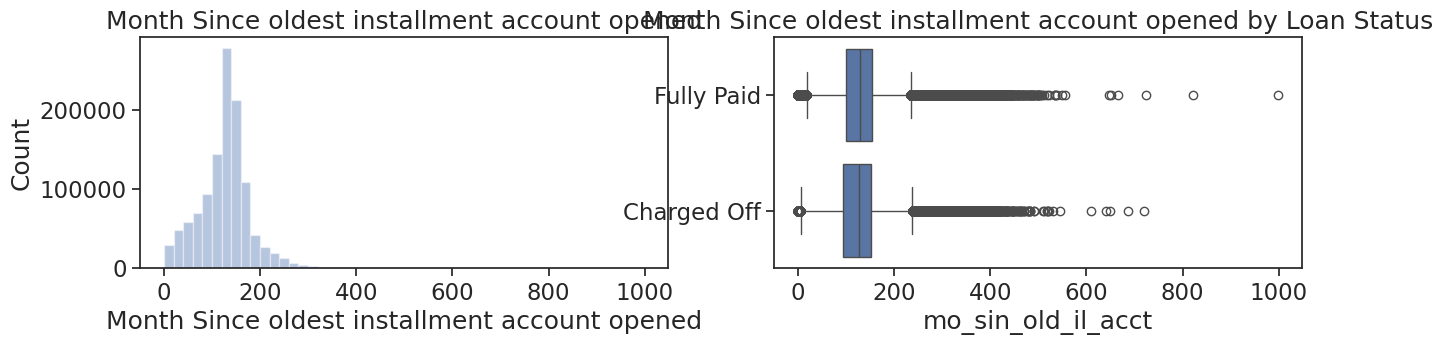

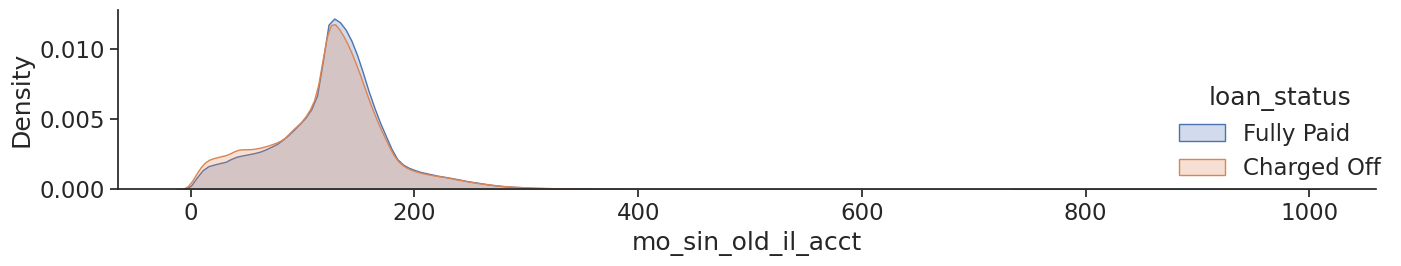

In [ ]:
plot_var('mo_sin_old_il_acct', 'Month Since oldest installment account opened', continuous=True)

# mo_sin_old_rev_tl_op
Data Dictionary: "Months since oldest revolving account opened."

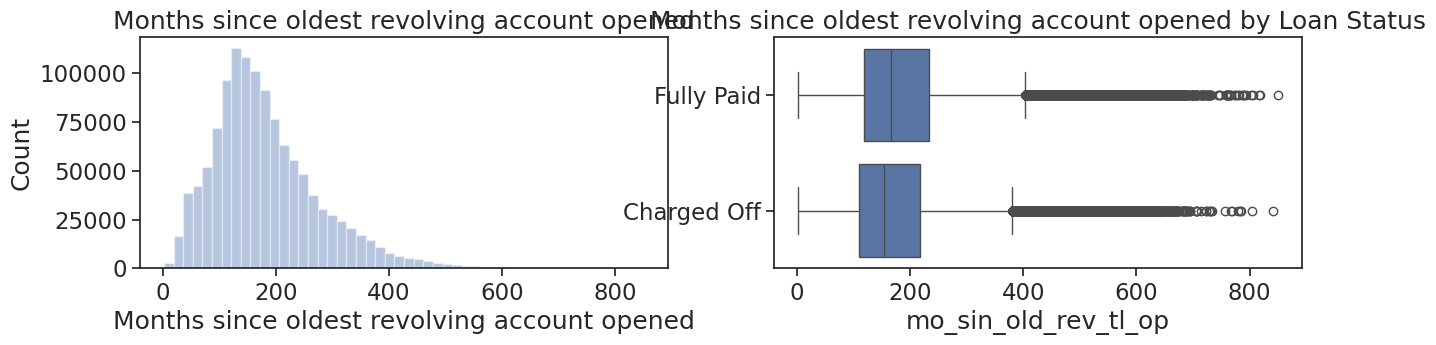

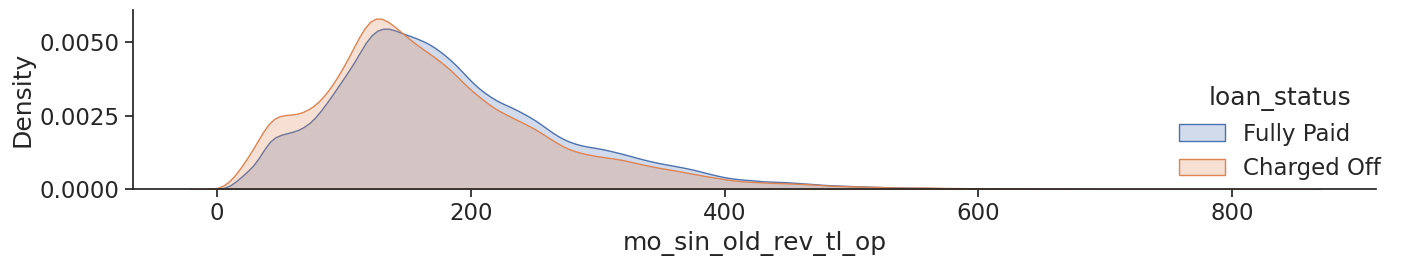

In [ ]:
plot_var('mo_sin_old_rev_tl_op', 'Months since oldest revolving account opened', continuous=True)

# mort_acc
Data Dictionary: "Number of mortgage accounts."

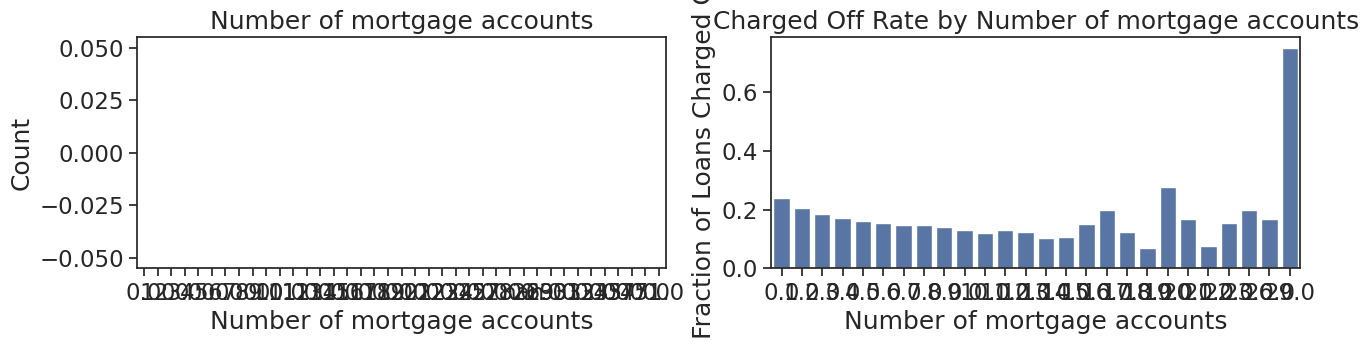

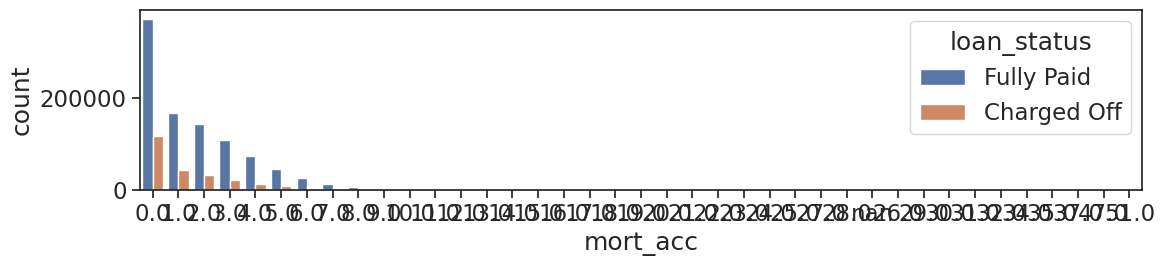

In [ ]:
plot_var('mort_acc', 'Number of mortgage accounts', continuous=False)

In [ ]:
df.mort_acc = df.mort_acc.map(lambda x: 6.0 if x > 6.0 else x)

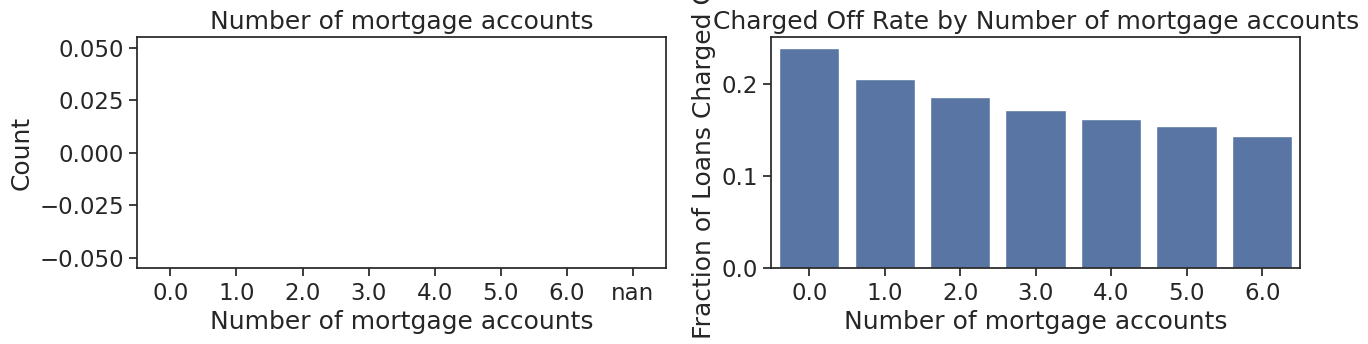

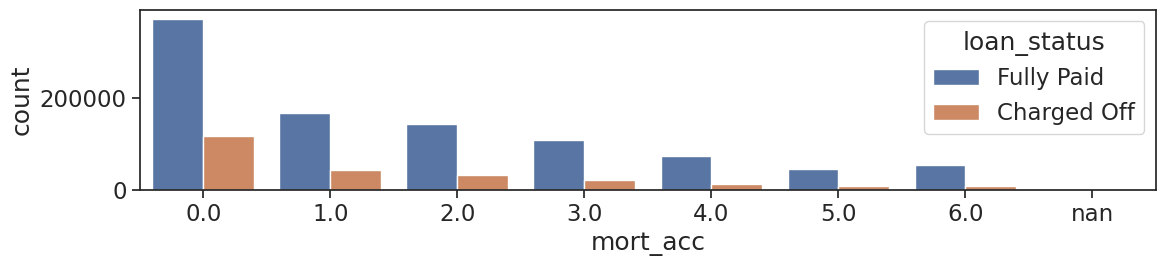

In [ ]:
plot_var('mort_acc', 'Number of mortgage accounts', continuous=False)

The more the number of mortgage accounts, the lower fraction of loans charged off.

In [ ]:
df.groupby('loan_status')['mort_acc'].describe()

count      mean       std  min  25%  50%  75%  max
loan_status                                                       
Charged Off  247891.0  1.341606  1.689645  0.0  0.0  1.0  2.0  6.0
Fully Paid   971446.0  1.694851  1.836874  0.0  0.0  1.0  3.0  6.0

In [ ]:
df['loan_status']

2           Fully Paid
7          Charged Off
9           Fully Paid
12         Charged Off
16          Fully Paid
              ...     
2132250    Charged Off
2132251     Fully Paid
2132258    Charged Off
2132280     Fully Paid
2132284     Fully Paid
Name: loan_status, Length: 1266618, dtype: object

In [ ]:
# Next, we will convert the "loan_status" column to a 0/1 "charged off" column. Fully Paid:0 Charged Off: 1
df['Charged_Off'] = df['loan_status'].apply(lambda s: float(s == 'Charged Off'))
drop_cols('loan_status')

In [ ]:
df['Charged_Off']

2          0.0
7          1.0
9          0.0
12         1.0
16         0.0
          ... 
2132250    1.0
2132251    0.0
2132258    1.0
2132280    0.0
2132284    0.0
Name: Charged_Off, Length: 1266618, dtype: float64

# Collinearity

In [ ]:
list_float = df.select_dtypes(exclude=['object']).columns

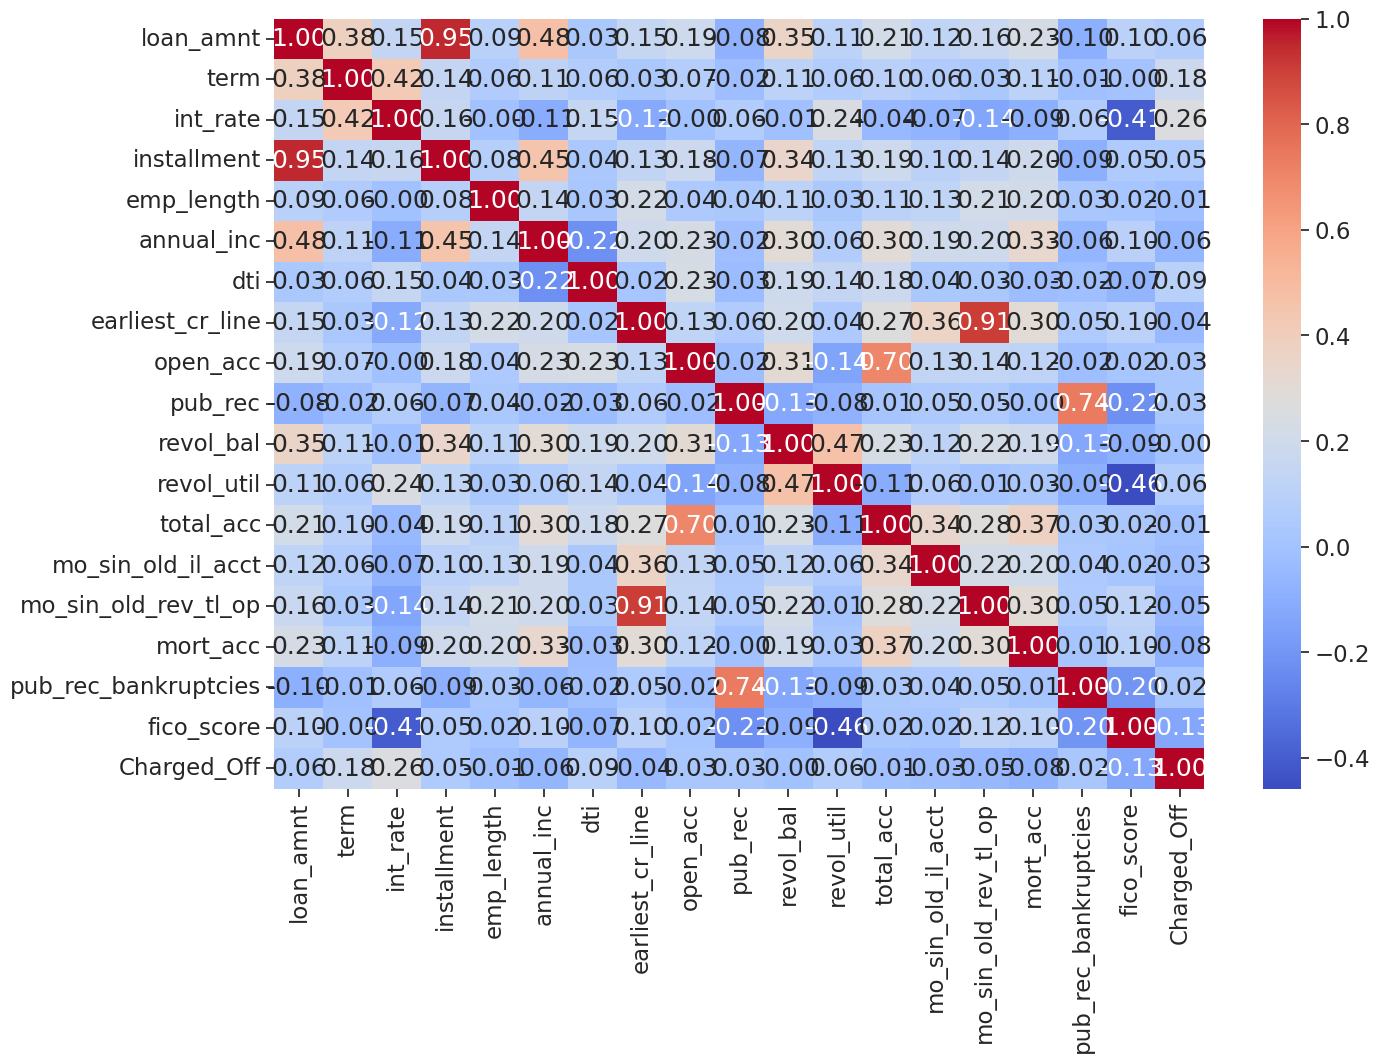

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
cm_df = sns.heatmap(df[list_float].corr(),annot=True, fmt = ".2f", cmap = "coolwarm", ax=ax)

The linearly correlated features are:

- "installment" vs "loan_amnt" (0.95)
- "mo_sin_old_rev_tl_op"* vs "earliest_cr_line" (0.91)
- "pub_rec_bankruptcies"* vs "pub_rec" (0.75)
- "total_acc" vs "open_acc" (0.69)

(*) with null values

Dependence of Charged-off on the predictors: "int_rate" is the most correlated one

In [ ]:
cor = df[list_float].corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.1) | (cor < -0.1)]

term         loan_amnt               0.381822
int_rate     loan_amnt               0.145200
             term                    0.419529
installment  loan_amnt               0.953359
             term                    0.143322
                                       ...   
fico_score   mort_acc                0.101691
             pub_rec_bankruptcies   -0.204212
Charged_Off  term                    0.176029
             int_rate                0.258260
             fico_score             -0.132098
Length: 89, dtype: float64

In [ ]:
df[["installment","loan_amnt","mo_sin_old_rev_tl_op","earliest_cr_line","total_acc","open_acc", "pub_rec_bankruptcies", "pub_rec"]].isnull().any()

installment             False
loan_amnt               False
mo_sin_old_rev_tl_op     True
earliest_cr_line        False
total_acc               False
open_acc                False
pub_rec_bankruptcies     True
pub_rec                 False
dtype: bool

In [ ]:
list_linear = ['installment', 'mo_sin_old_rev_tl_op','total_acc','pub_rec_bankruptcies']

In [ ]:
linear_corr = pd.DataFrame()

In [ ]:
# Pearson coefficients
for col in df[list_float].columns:
    linear_corr.loc[col, 'pearson_corr'] = df[col].corr(df['Charged_Off'])
linear_corr['abs_pearson_corr'] = abs(linear_corr['pearson_corr'])

Sort the results by the absolute value of the Pearson Correlation

In [ ]:
print(linear_corr.columns)

Index(['index', 'pearson_corr', 'abs_pearson_corr'], dtype='object')


In [ ]:
linear_corr['index']

0                                   int_rate
int_rate                                 NaN
1                                       term
term                                     NaN
fico_score                               NaN
2                                 fico_score
dti                                      NaN
3                                        dti
4                                   mort_acc
mort_acc                                 NaN
5                                  loan_amnt
loan_amnt                                NaN
6                                 annual_inc
annual_inc                               NaN
7                                 revol_util
revol_util                               NaN
8                                installment
installment                              NaN
mo_sin_old_rev_tl_op                     NaN
9                       mo_sin_old_rev_tl_op
earliest_cr_line                         NaN
10                          earliest_cr_line
open_acc                                 NaN
11                                  open_acc
12                                   pub_rec
pub_rec                                  NaN
13                        mo_sin_old_il_acct
mo_sin_old_il_acct                       NaN
pub_rec_bankruptcies                     NaN
14                      pub_rec_bankruptcies
15                                emp_length
emp_length                               NaN
total_acc                                NaN
16                                 total_acc
revol_bal                                NaN
17                                 revol_bal
Name: index, dtype: object

In [ ]:
linear_corr.sort_values('abs_pearson_corr', ascending=False, inplace=True)
linear_corr.drop('abs_pearson_corr', axis=1, inplace=True)
if 'Charged_Off' in linear_corr.index:
    linear_corr.drop('Charged_Off', axis=0, inplace=True)
else:
    print("'Charged_Off' is not in the index.")

In [ ]:
linear_corr.reset_index(inplace=True)

In [ ]:
linear_corr

index  pearson_corr
0               int_rate      0.258260
1                   term      0.176029
2             fico_score     -0.132098
3                    dti      0.089047
4               mort_acc     -0.078393
5              loan_amnt      0.064934
6             annual_inc     -0.063824
7             revol_util      0.061830
8            installment      0.050762
9   mo_sin_old_rev_tl_op     -0.050620
10      earliest_cr_line     -0.044411
11              open_acc      0.029575
12               pub_rec      0.029507
13    mo_sin_old_il_acct     -0.026102
14  pub_rec_bankruptcies      0.024421
15            emp_length     -0.014389
16             total_acc     -0.010791
17             revol_bal     -0.004603

The variables most linearly correlated with our target variable are interest rate, loan term, Fico Score and debt-to-income ratio. The least correlated features are the revolving balance, employment length, and public record.

In [ ]:
drop_cols(list_linear)

In [ ]:
df.shape

(1266618, 25)

# Categorical Variables

In [ ]:
#dummy_list =['sub_grade','home_ownership','verification_status','purpose','addr_state','initial_list_status','application_type']

In [ ]:
#df[dummy_list].isnull().any()

sub_grade              False
home_ownership         False
verification_status    False
purpose                False
addr_state             False
initial_list_status    False
application_type       False
dtype: bool

In [ ]:
#df = pd.get_dummies(df, columns=dummy_list, drop_first=True)

In [ ]:
df.shape

(1266618, 25)

# Modeling

In [ ]:
df_copy = df.copy()

In [ ]:
outcome='Charged_Off'

# split into train and validation sets
data_train, data_val = train_test_split(df_copy, test_size= 0.3, stratify=df[outcome], random_state= 0);

X_train = data_train.drop(columns=outcome)
y_train = data_train[outcome]

X_test = data_val.drop(columns=outcome)
y_test = data_val[outcome]

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from xgboost import XGBClassifier

# Identify problematic columns
categorical_cols = ['grade']
date_cols = ['issue_d']
drop_cols = ['url']

# Encode categorical columns
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])

# Convert date columns to datetime and extract features
for col in date_cols:
    X_train[col] = pd.to_datetime(X_train[col])
    X_train[f'{col}_year'] = X_train[col].dt.year
    X_train[f'{col}_month'] = X_train[col].dt.month
    X_train.drop(columns=[col], inplace=True)

# Drop non-useful columns
X_train.drop(columns=drop_cols, inplace=True)

# Ensure data types are numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')

# Remove any NaNs introduced during conversion
X_train = X_train.fillna(0)

                Columns  Feature_Importances
3                 grade             0.729923
1                  term             0.085852
22         issue_d_year             0.031179
20             mort_acc             0.030281
2              int_rate             0.024774
21           fico_score             0.012455
11                  dti             0.011766
0             loan_amnt             0.010316
5            emp_length             0.009577
7            annual_inc             0.008915
23        issue_d_month             0.007927
15            revol_bal             0.007188
14              pub_rec             0.006941
13             open_acc             0.006391
12     earliest_cr_line             0.005740
19   mo_sin_old_il_acct             0.005580
16           revol_util             0.005195
10           addr_state             0.000000
9               purpose             0.000000
17  initial_list_status             0.000000


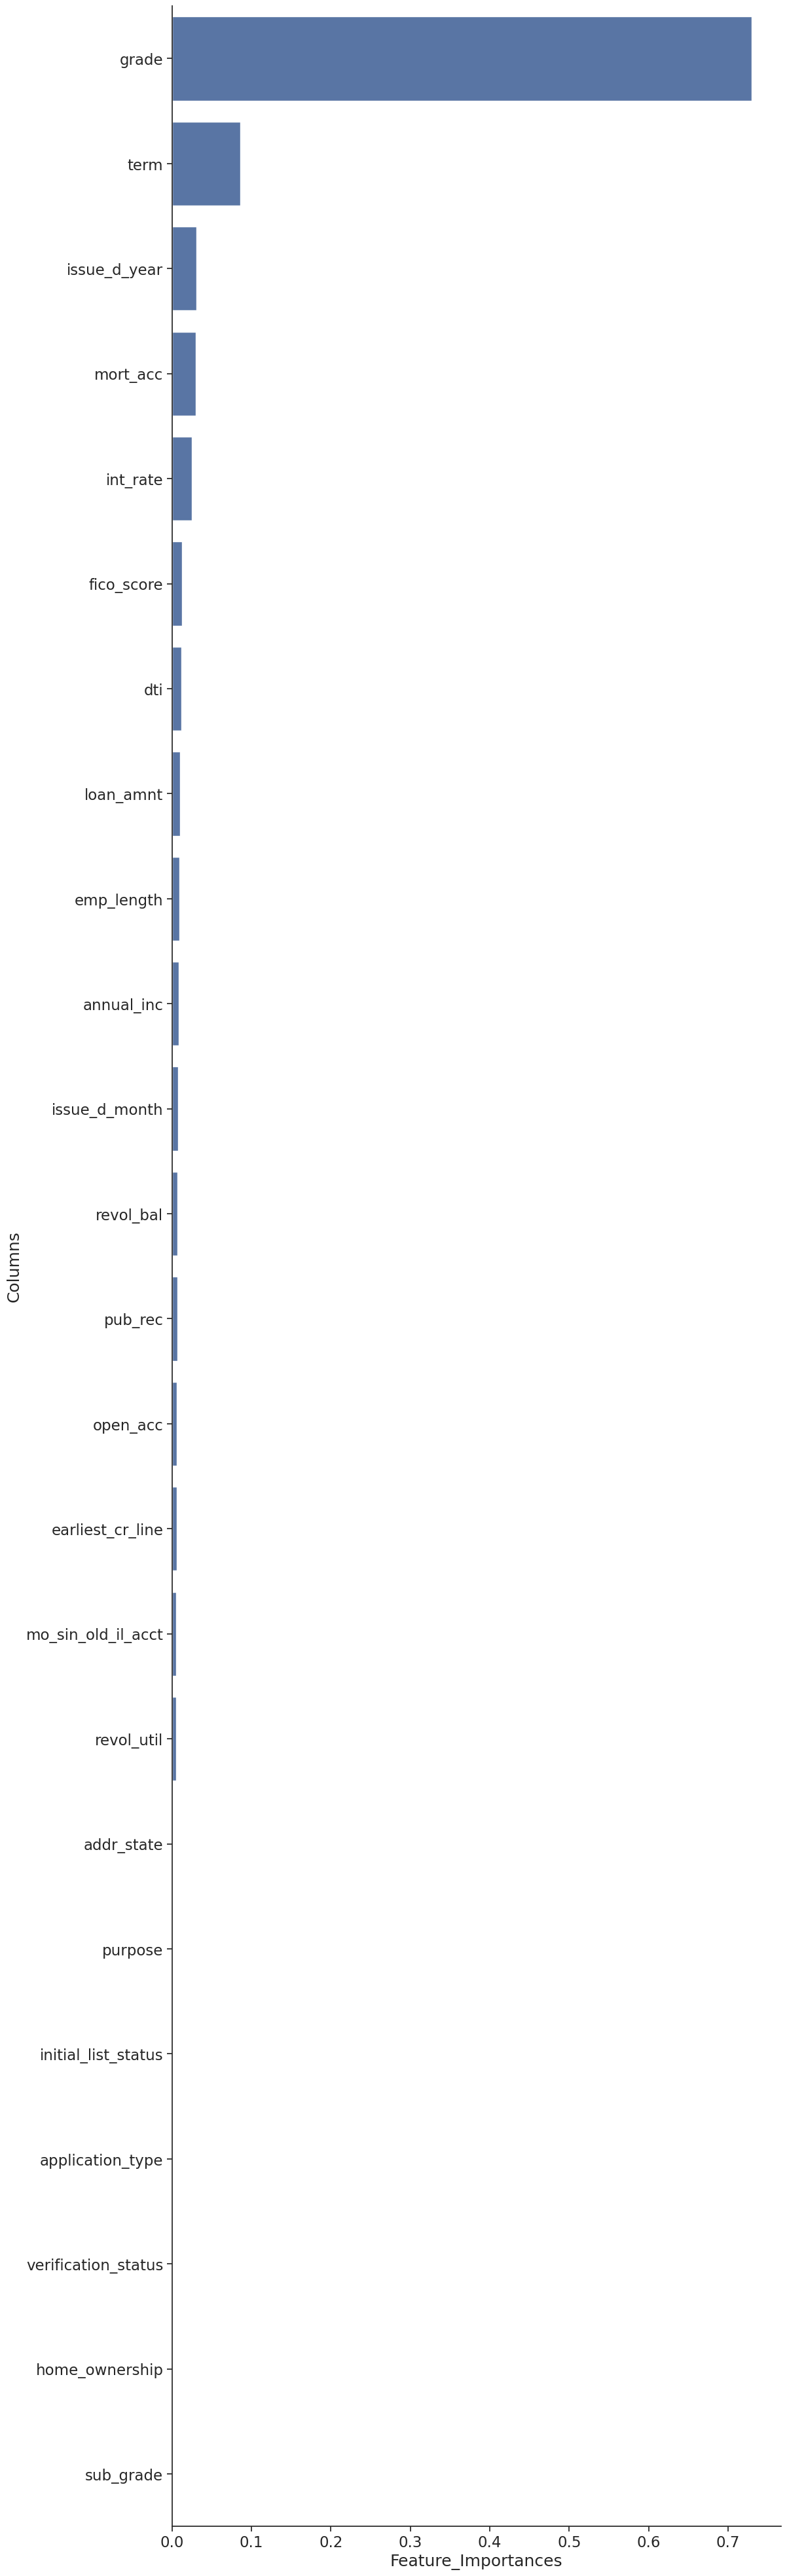

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Train XGBoost classifier, allowing overfitting
xgb_model = XGBClassifier(n_estimators=100, max_depth=None, use_label_encoder=False, eval_metric='logloss').fit(X_train, y_train)

# View feature importances as a dataframe
importances_xgb = pd.DataFrame({'Columns': X_train.columns, 'Feature_Importances': xgb_model.feature_importances_})
importances_xgb = importances_xgb.sort_values(by='Feature_Importances', ascending=False)
print(importances_xgb.head(20))

# Plot feature importances
fig, ax = plt.subplots(figsize=(12, 50))
sns.barplot(x=importances_xgb['Feature_Importances'], y=importances_xgb['Columns'], ax=ax)
sns.despine()
plt.show()

In [ ]:
X_train.head(10)

loan_amnt  term  int_rate  grade  emp_length  annual_inc    dti  \
1897231    20000.0    60     20.49      4        10.0    4.845104  16.54   
574267     16000.0    36     16.99      3        10.0    4.915579  29.85   
1442884    23000.0    36      7.90      0        10.0    4.857339  21.88   
1416973    14600.0    60     16.99      3        10.0    4.662767  18.05   
574357      6375.0    36     13.98      2         4.0    4.462413  15.44   
279224      7500.0    36     10.78      1         0.0    4.494169  29.26   
1258546    12000.0    36      7.97      0         3.0    4.602071  24.75   
1654122    10000.0    36      5.32      0         0.0    5.352184   4.23   
1577200    10000.0    36     20.49      4         2.0    4.623260  17.20   
664037      4000.0    36     21.18      4         4.0    4.576928  10.81   

         earliest_cr_line  open_acc  pub_rec  revol_bal  revol_util  \
1897231         20.158904      11.0      0.0   3.921374        56.4   
574267          28.583562      18.0      0.0   4.403103        63.1   
1442884         35.169863       6.0      0.0   4.569222        74.3   
1416973         22.909589      14.0      0.0   3.735918        26.0   
574357          16.408219       8.0      0.0   3.444357        19.9   
279224          15.490411       5.0      0.0   3.874482        99.9   
1258546         14.819178       9.0      1.0   3.682686        13.8   
1654122         22.994521      12.0      0.0   4.808630        10.1   
1577200         18.578082       8.0      0.0   3.877141        97.9   
664037          17.410959      21.0      0.0   3.398461        61.0   

         mo_sin_old_il_acct  mort_acc  fico_score  sub_grade_A2  sub_grade_A3  \
1897231               126.0       2.0       687.0             0             0   
574267                142.0       1.0       667.0             0             0   
1442884               288.0       6.0       702.0             0             0   
1416973               104.0       1.0       747.0             0             0   
574357                 13.0       0.0       737.0             0             0   
279224                 75.0       0.0       697.0             0             0   
1258546                93.0       0.0       717.0             0             0   
1654122               167.0       4.0       797.0             0             0   
1577200                 0.0       0.0       662.0             0             0   
664037                 80.0       0.0       662.0             0             0   

         sub_grade_A4  sub_grade_A5  sub_grade_B1  sub_grade_B2  sub_grade_B3  \
1897231             0             0             0             0             0   
574267              0             0             0             0             0   
1442884             1             0             0             0             0   
1416973             0             0             0             0             0   
574357              0             0             0             0             0   
279224              0             0             0             0             0   
1258546             0             1             0             0             0   
1654122             0             0             0             0             0   
1577200             0             0             0             0             0   
664037              0             0             0             0             0   

         sub_grade_B4  sub_grade_B5  sub_grade_C1  sub_grade_C2  sub_grade_C3  \
1897231             0             0             0             0             0   
574267              0             0             0             0             0   
1442884             0             0             0             0             0   
1416973             0             0             0             0             0   
574357              0             0             0             0             1   
279224              1             0             0             0             0   
1258546             0             0    

In [ ]:
# Apply the same preprocessing to X_test
for col in categorical_cols:
    X_test[col] = le.transform(X_test[col])  # Use the fitted encoder from X_train

for col in date_cols:
    X_test[col] = pd.to_datetime(X_test[col])
    X_test[f'{col}_year'] = X_test[col].dt.year
    X_test[f'{col}_month'] = X_test[col].dt.month
    X_test.drop(columns=[col], inplace=True)

X_test.drop(columns=drop_cols, inplace=True)

# Ensure all columns are numeric
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Handle any missing values
X_test = X_test.fillna(0)

# Align columns between X_train and X_test
X_test = X_test[X_train.columns]

In [ ]:
X_test.head(10)

loan_amnt  term  int_rate  grade  emp_length  annual_inc    dti  \
1656434    20000.0    60     14.33      2         8.0    4.964736  16.99   
690864     10000.0    36      8.90      0         1.0    4.755882  20.93   
1846470     4000.0    36     10.99      1         0.0    4.361747  19.26   
317863      7000.0    36      8.99      1         1.0    4.748196   6.92   
535365      5000.0    36      8.39      0        10.0    4.698979  17.14   
1679507    20000.0    36      9.17      1        10.0    4.732402  12.13   
1718083    26600.0    60     21.99      5         3.0    4.845104  34.05   
63637       6000.0    36     12.74      2        10.0    4.778158  10.72   
1470162    10000.0    36     13.05      1        10.0    4.556315  21.17   
2045152    30000.0    36     23.87      4         0.0    0.000000   0.00   

         earliest_cr_line  open_acc  pub_rec  revol_bal  revol_util  \
1656434         20.493151      13.0      1.0   4.348441        73.4   
690864          21.663014      13.0      0.0   3.978956        73.8   
1846470         17.660274       4.0      0.0   3.787319        56.7   
317863          37.254795       6.0      0.0   3.717338        28.7   
535365          21.824658       6.0      1.0   2.727541        29.6   
1679507         27.665753      10.0      0.0   4.030195        46.8   
1718083         19.410959      19.0      0.0   4.423524        94.0   
63637           19.821918       7.0      1.0   3.761627        70.4   
1470162         19.241096      14.0      1.0   3.823539        47.9   
2045152         16.238356      10.0      0.0   4.453899        73.5   

         mo_sin_old_il_acct  mort_acc  fico_score  sub_grade_A2  sub_grade_A3  \
1656434               137.0       0.0       662.0             0             0   
690864                 72.0       1.0       702.0             0             0   
1846470                77.0       0.0       672.0             0             0   
317863                122.0       1.0       687.0             0             0   
535365                136.0       2.0       667.0             0             0   
1679507               150.0       2.0       727.0             0             0   
1718083               122.0       1.0       717.0             0             0   
63637                 134.0       1.0       662.0             0             0   
1470162                17.0       0.0       707.0             0             0   
2045152                 0.0       0.0       662.0             0             0   

         sub_grade_A4  sub_grade_A5  sub_grade_B1  sub_grade_B2  sub_grade_B3  \
1656434             0             0             0             0             0   
690864              0             1             0             0             0   
1846470             0             0             0             0             0   
317863              0             0             1             0             0   
535365              0             1             0             0             0   
1679507             0             0             0             1             0   
1718083             0             0             0             0             0   
63637               0             0             0             0             0   
1470162             0             0             0             0             0   
2045152             0             0             0             0             0   

         sub_grade_B4  sub_grade_B5  sub_grade_C1  sub_grade_C2  sub_grade_C3  \
1656434             0             0             0             0             0   
690864              0             0             0             0             0   
1846470             1             0             0             0             0   
317863              0             0             0             0             0   
535365              0             0             0             0             0   
1679507             0             0             0             0             0   
1718083             0             0    

In [ ]:
# Predict on the training set
y_train_pred_xgb = xgb_model.predict(X_train)

# Calculate accuracy on the training set
train_accuracy_xgb = accuracy_score(y_train, y_train_pred_xgb)
print(f"Training Accuracy XGB: {train_accuracy_xgb}")

# Predict on the test set
y_test_pred_xgb = xgb_model.predict(X_test)

# Calculate accuracy on the test set
test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)
print(f"Testing Accuracy XGB: {test_accuracy_xgb}")

Training Accuracy XGB: 0.8073721679343854
Testing Accuracy XGB: 0.8036032906475502


# Random Forest

Training Accuracy: 0.9999842099089589
Testing Accuracy: 0.8018163827088366


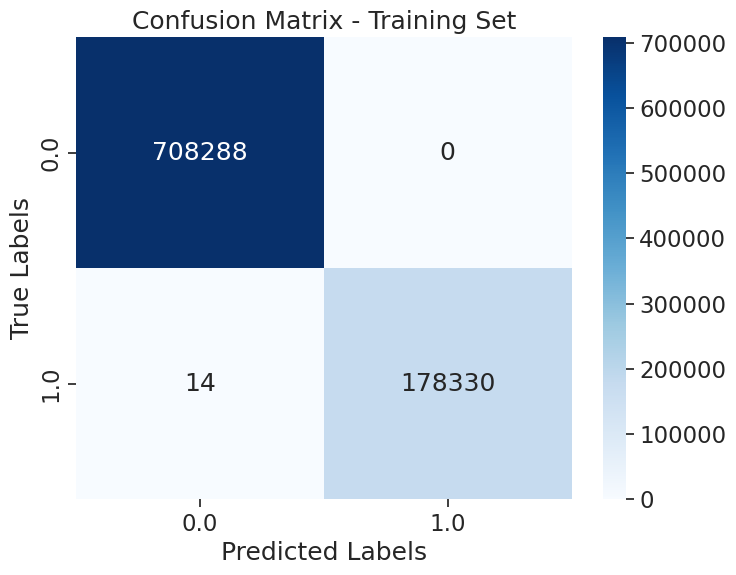

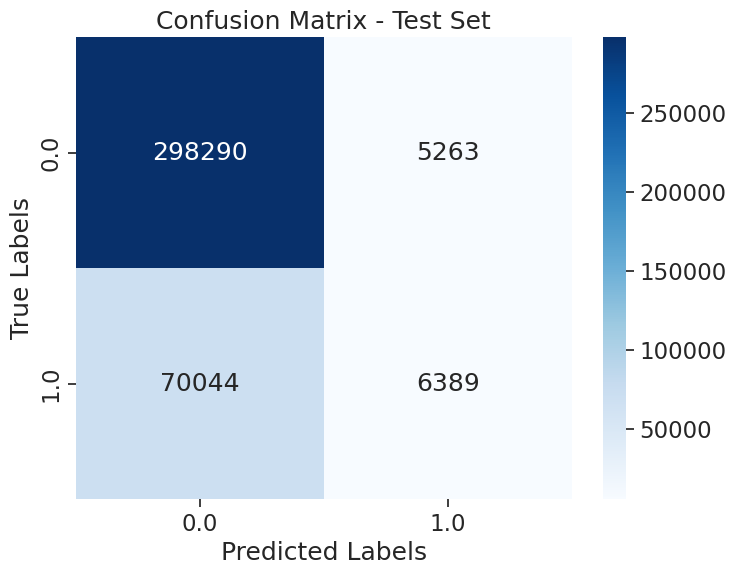

In [ ]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)

# Predict on the training set
y_train_pred = rf_model.predict(X_train)

# Calculate accuracy on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")

# Predict on the test set
y_test_pred = rf_model.predict(X_test)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy: {test_accuracy}")

# Confusion matrix for training set
train_conf_matrix = confusion_matrix(y_train, y_train_pred)

# Plot confusion matrix heatmap for training set
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title('Confusion Matrix - Training Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Confusion matrix for test set
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix heatmap for test set
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()